### This notebook enables you to download Landsat imagery (nbart and ao masks) from DEA AWSs3 repository.

- It produces a compostite image using the nbart bands,
- Checks if the requried directory structure exists, if it does not exist it will create it, 
- It then saves the nbart composite image and the two ao mask layers into the DCCEEW file store. 

In [1]:
import sys
import argparse
import urllib.request, json
import pandas as pd
import geopandas as gpd
import xarray as xr
import odc.aws
from pprint import pprint
from datacube.testutils.io import rio_slurp_xarray
import glob, os
import rasterio
import shutil
import pathlib

- provide the directory and path to save your imagery on your laptop 
- this notebook will download and process the imagery on your laptop, it keeps a local copy and then copies it into the corporate file store. 

In [2]:
# provide the path on your device you are saving the imagery too
local_dir = r'D:\\data\\working\\temp_image\\'
# path to the corporate file store 
file_store = r'D:\\data\\working\\lsat\\test\\'
# cd to the local directory to download and process the imagery
os.chdir(local_dir)
print ('You are working in this directory: ',os.getcwd())

You are working in this directory:  D:\data\working\temp_image


In [3]:
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [4]:
# load the landsat path/row of interest - edit the path to point at your local copy
wrs2 = gpd.read_file("D:\data\wrs2_pathrow\WRS2_AU_centroid_buff50m.shp") 

# define the pathrow of interest
pr = int('106069')

path_row = wrs2[(wrs2['WRSPR'] == pr)]
bbox = list(path_row.total_bounds)
print (bbox)

[130.37254108763415, -13.014652165057779, 130.37346110963145, -13.013748256069066]


In [5]:
"""Select the Landsat sensor"""
#product = 'ga_ls5t_ard_3'
#product = 'ga_ls7e_ard_3'
product = 'ga_ls8c_ard_3'
#product = 'ga_ls9c_ard_3'

"""Provide the start and finish dates"""
start_time = '2021-05-01'
end_time = '2024-09-30'
bbox = bbox

In [6]:
# the maximum number of images that will be returned is limited to 120 - if you what to see more increase the limit variable
root_url = 'https://explorer.dea.ga.gov.au/stac'
stac_url = f'{root_url}/search?collection={product}&time={start_time}/{end_time}&bbox={str(bbox).replace(" ", "")}&limit=120'
print(stac_url)

https://explorer.dea.ga.gov.au/stac/search?collection=ga_ls8c_ard_3&time=2021-05-01/2024-09-30&bbox=[130.37254108763415,-13.014652165057779,130.37346110963145,-13.013748256069066]&limit=120


In [7]:
with urllib.request.urlopen(stac_url) as url:
    data = json.loads(url.read().decode())
pprint(data, depth=1)

{'context': {...},
 'features': [...],
 'links': [...],
 'numberMatched': 72,
 'numberReturned': 72,
 'type': 'FeatureCollection'}


<AxesSubplot:>

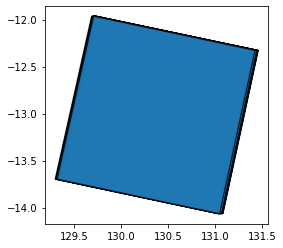

In [8]:
# Convert features to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data['features'])

# Plot the footprints of each dataset
gdf.plot(alpha=0.8, edgecolor='black')

In [9]:
gdf

geometry  \
0   POLYGON ((131.04719 -14.06350, 131.04717 -14.0...   
1   POLYGON ((129.69982 -11.96583, 129.69984 -11.9...   
2   POLYGON ((129.31402 -13.69636, 129.31339 -13.6...   
3   POLYGON ((129.71521 -11.96556, 129.71527 -11.9...   
4   POLYGON ((129.34990 -13.69681, 129.34940 -13.6...   
..                                                ...   
67  POLYGON ((129.72044 -11.96634, 129.72050 -11.9...   
68  POLYGON ((129.33524 -13.69731, 129.33448 -13.6...   
69  POLYGON ((129.34183 -13.69741, 129.34183 -13.6...   
70  POLYGON ((129.31735 -13.69620, 129.31728 -13.6...   
71  POLYGON ((129.32373 -13.69668, 129.32374 -13.6...   

                                        title   gsd  \
0   ga_ls8c_ard_3-2-0_106069_2021-05-11_final  15.0   
1   ga_ls8c_ard_3-2-0_106069_2021-05-27_final  15.0   
2   ga_ls8c_ard_3-2-0_106069_2021-06-12_final  15.0   
3   ga_ls8c_ard_3-2-0_106069_2021-06-28_final  15.0   
4   ga_ls8c_ard_3-2-0_106069_2021-07-14_final  15.0   
..                                        ...   ...   
67  ga_ls8c_ard_3-2-1_106069_2024-04-17_final  15.0   
68  ga_ls8c_ard_3-2-1_106069_2024-05-03_final  15.0   
69  ga_ls8c_ard_3-2-1_106069_2024-05-19_final  15.0   
70    ga_ls8c_ard_3-2-1_106069_2024-06-04_nrt  15.0   
71    ga_ls8c_ard_3-2-1_106069_2024-06-20_nrt  15.0   

                        created  gqa:abs_x  gqa:abs_y  gqa:cep90  proj:epsg  \
0   2021-05-11T01:22:44.013793Z       0.38       0.57       0.78      32652   
1   2021-05-27T01:22:53.979916Z       0.28       0.33       0.57      32652   
2   2021-06-12T01:23:00.931692Z       0.27       0.33       0.49      32652   
3   2021-06-28T01:23:05.056260Z       0.30       0.38       0.60      32652   
4   2021-07-25T10:47:49.904112Z       0.34       0.37       0.59      32652   
..                          ...        ...        ...        ...        ...   
67  2024-05-09T10:37:25.369755Z       0.23       0.29       0.41      32652   
68  2024-05-16T10:43:04.982441Z       0.30       0.41       0.61      32652   
69  2024-06-12T11:00:54.030684Z       0.28       0.34       0.55      32652   
70  2024-06-04T04:33:41.626680Z       0.74       0.92       0.75      32652   
71  2024-06-20T17:07:58.544396Z       0.42       0.47       0.68      32652   

    fmask:snow  gqa:abs_xy  ...  gqa:abs_iterative_mean_x  \
0     0.000000        0.69  ...                      0.19   
1     0.000000        0.44  ...                      0.17   
2     0.000000        0.42  ...                      0.14   
3     0.000000        0.48  ...                      0.18   
4     0.000000        0.50  ...                      0.19   
..         ...         ...  ...                       ...   
67    0.000002        0.37  ...                      0.12   
68    0.000000        0.51  ...                      0.15   
69    0.000000        0.44  ...                      0.15   
70    0.000000        1.18  ...                      0.25   
71    0.000000        0.63  ...                      0.19   

    gqa:abs_iterative_mean_y landsat:landsat_scene_id  \
0                       0.24    LC81060692021131LGN00   
1                       0.19    LC81060692021147LGN00   
2                       0.18    LC81060692021163LGN00   
3                       0.22    LC81060692021179LGN00   
4                       0.21    LC81060692021195LGN00   
..                       ...                      ...   
67                      0.16    LC81060692024108LGN00   
68                      0.22    LC81060692024124LGN00   
69                      0.20    LC81060692024140LGN00   
70                      0.31    LC81060692024156LGN00   
71                      0.25    LC81060692024172LGN00   

   gqa:abs_iterative_mean_xy  landsat:collection_number  \
0                       0.31                          1   
1                       0.26                          1   
2                       0.23                          1   
3                       0.29                          1   
4                       0.28         

In [10]:
# This enables you to query the imagery available and remove the images with higher than acceptable cloud.
# beware that this is an estimate of cloud cover in the imagery and sometimes it is not particularly accurate. 
# If you don’t care about cloud cover and want to download or look at all the imagery available un-hash line six.

cl = gdf[(gdf['eo:cloud_cover'] < 1)]
cl = gdf
print ('Total number of images: ', len(cl.index))
print (cl.index)

Total number of images:  72
RangeIndex(start=0, stop=72, step=1)


### You can now inspect the thumbnail for each of the images in your selected query. 
- The image index and name are printed out along with the thumbnail 

Sorry there are no thumbnails available for: Index: 0  image: ga_ls8c_ard_3-2-0_106069_2021-05-11_final

Click here https://maps.dea.ga.gov.au/ if you would like to look at a particular image before downloading it.
Here are your centre cordinates for your Landsat Scene to input into DEA maps: [-13.014652165057779, 130.37346110963145]

**************************************************************************************************************************
Sorry there are no thumbnails available for: Index: 1  image: ga_ls8c_ard_3-2-0_106069_2021-05-27_final

Click here https://maps.dea.ga.gov.au/ if you would like to look at a particular image before downloading it.
Here are your centre cordinates for your Landsat Scene to input into DEA maps: [-13.014652165057779, 130.37346110963145]

**************************************************************************************************************************
Sorry there are no thumbnails available for: Index: 2  image: ga_ls8c_ard_3-2-0_

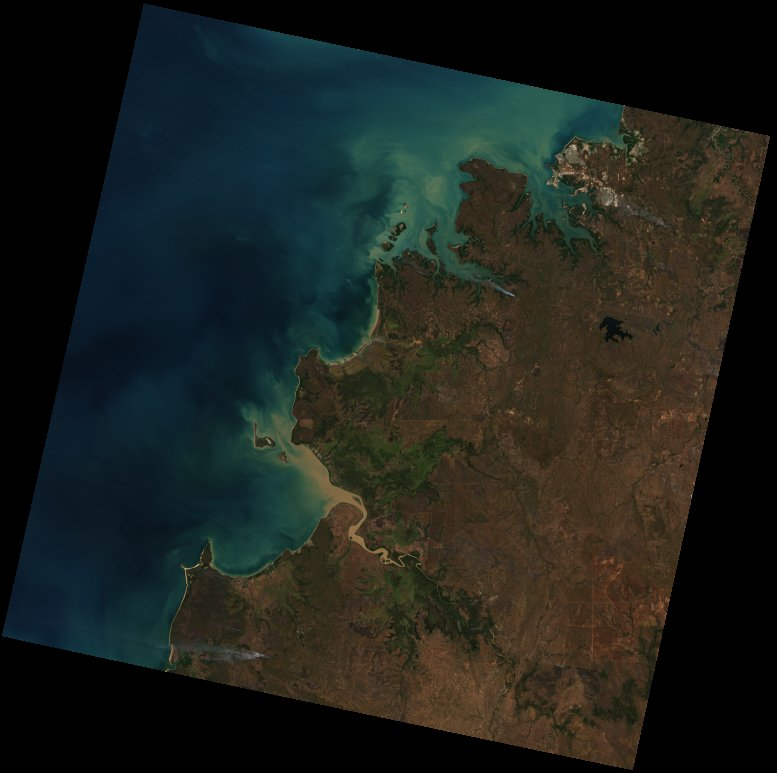

index: 4  Image: ga_ls8c_nbart_3-2-0_106069_2021-07-14_final_thumbnail.jpg


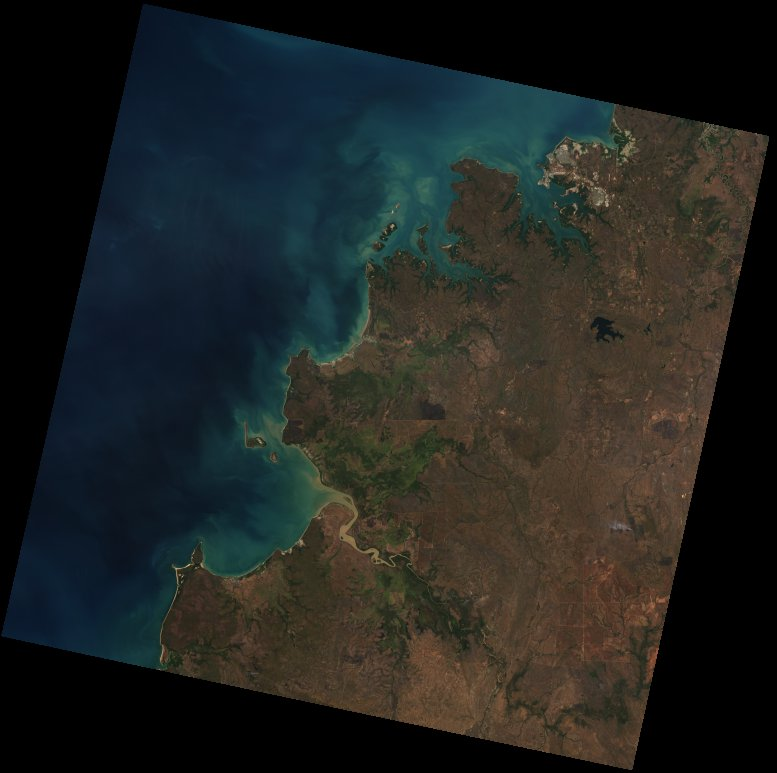

index: 5  Image: ga_ls8c_nbart_3-2-0_106069_2021-07-30_final_thumbnail.jpg


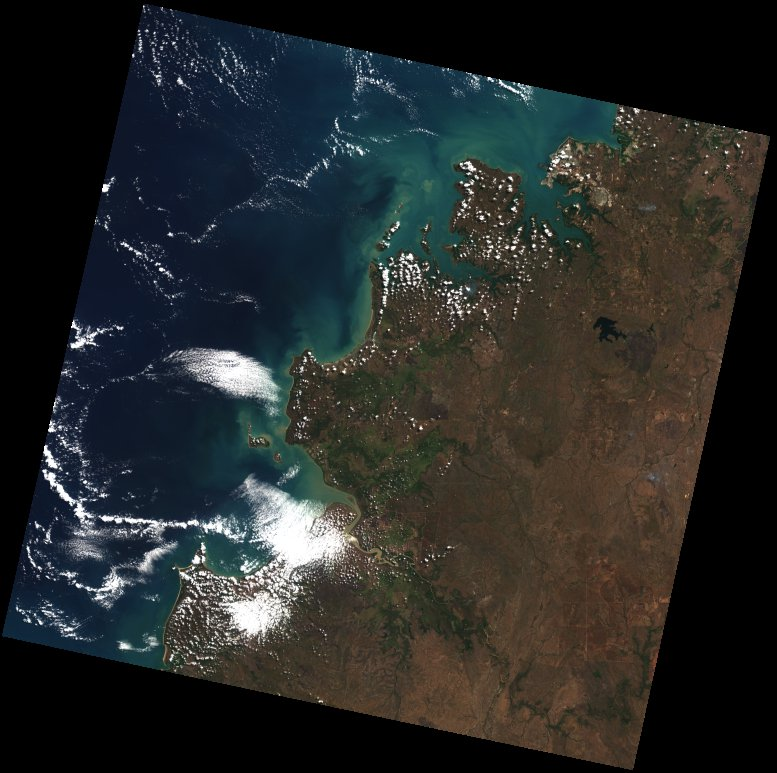

index: 6  Image: ga_ls8c_nbart_3-2-0_106069_2021-08-15_final_thumbnail.jpg


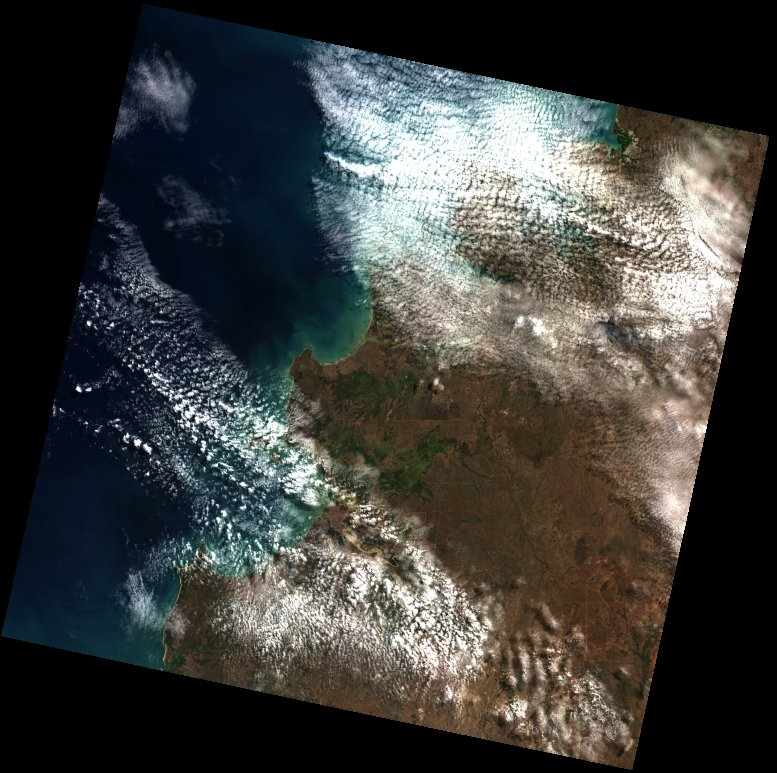

index: 7  Image: ga_ls8c_nbart_3-2-0_106069_2021-08-31_final_thumbnail.jpg


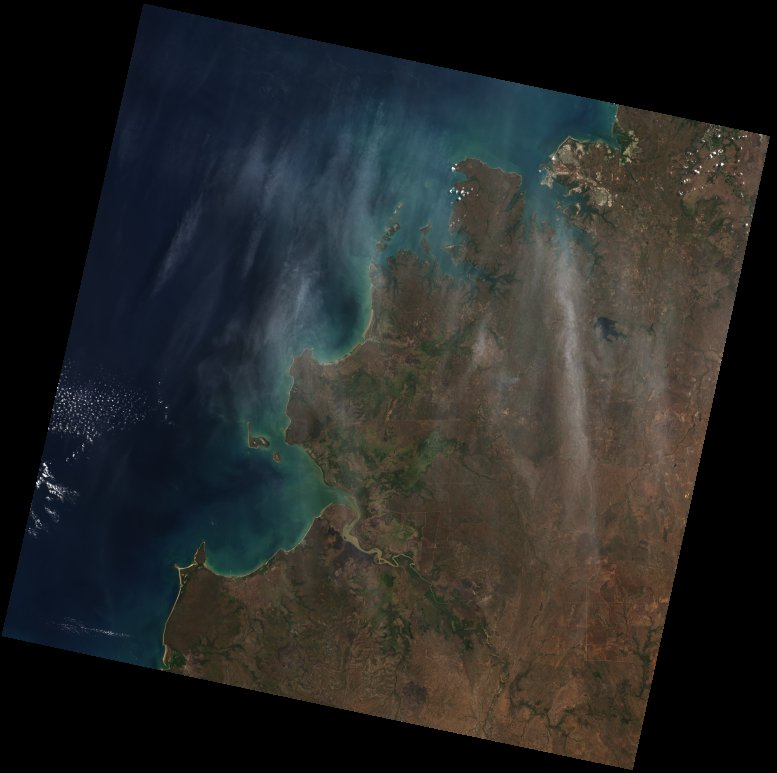

index: 8  Image: ga_ls8c_nbart_3-2-0_106069_2021-09-16_final_thumbnail.jpg


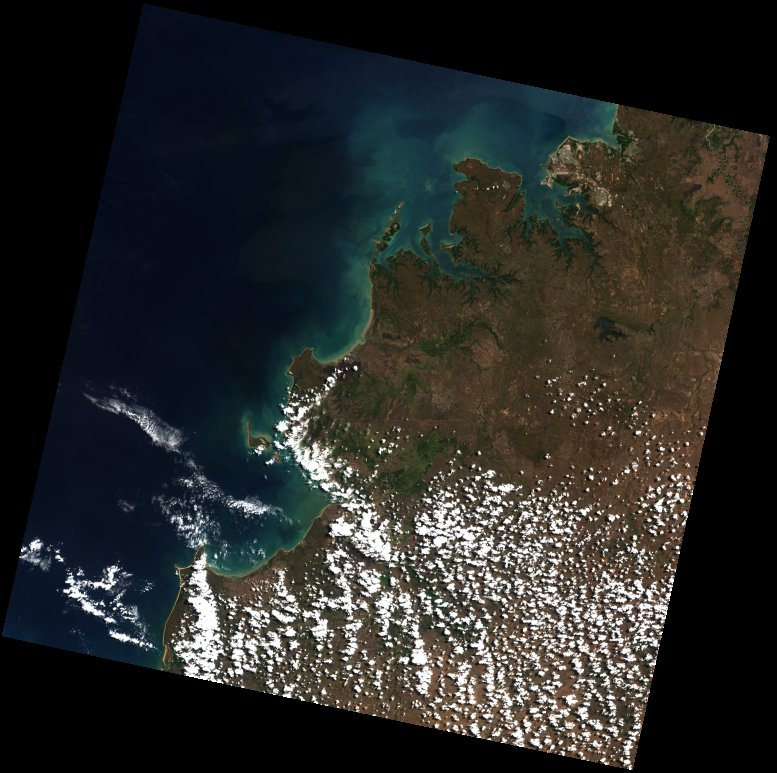

index: 9  Image: ga_ls8c_nbart_3-2-0_106069_2021-10-02_final_thumbnail.jpg


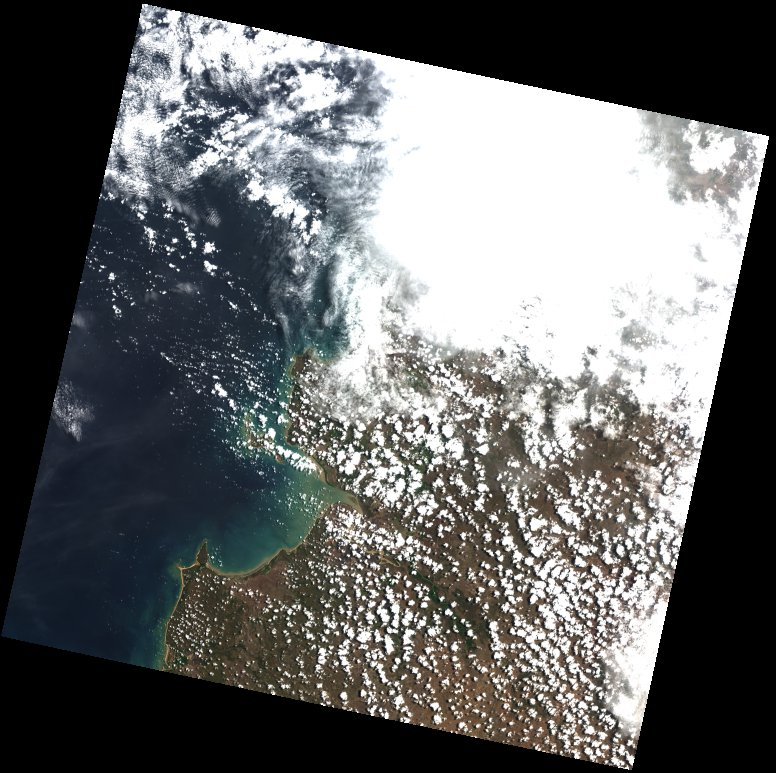

index: 10  Image: ga_ls8c_nbart_3-2-0_106069_2021-10-18_final_thumbnail.jpg


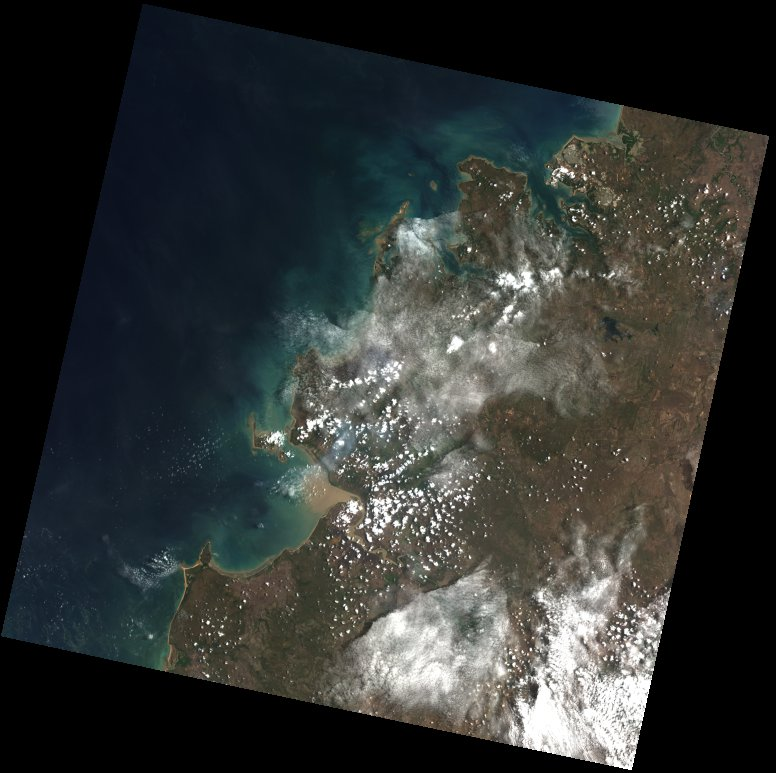

index: 11  Image: ga_ls8c_nbart_3-2-0_106069_2021-11-03_final_thumbnail.jpg


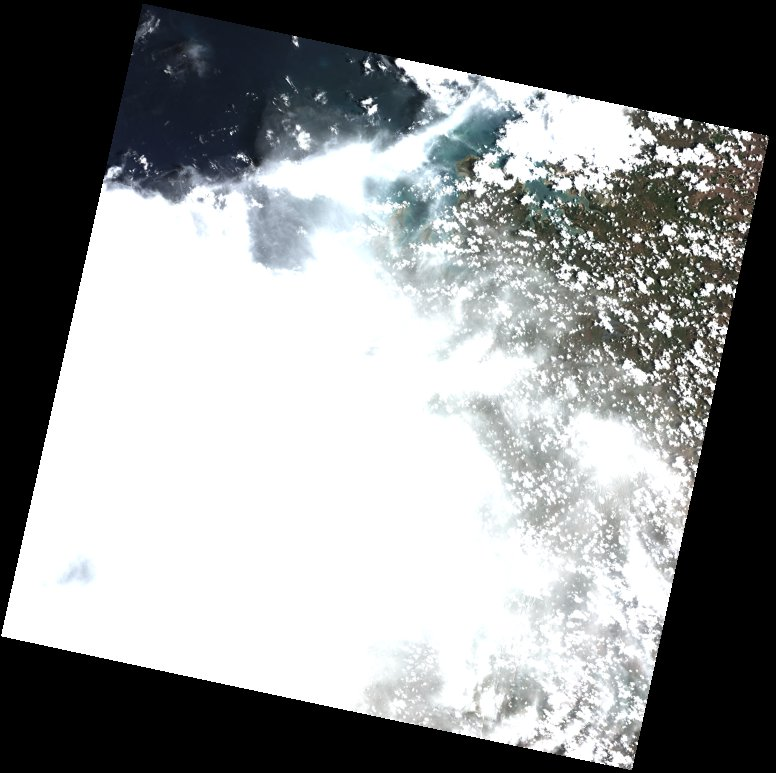

index: 12  Image: ga_ls8c_nbart_3-2-0_106069_2021-11-19_final_thumbnail.jpg


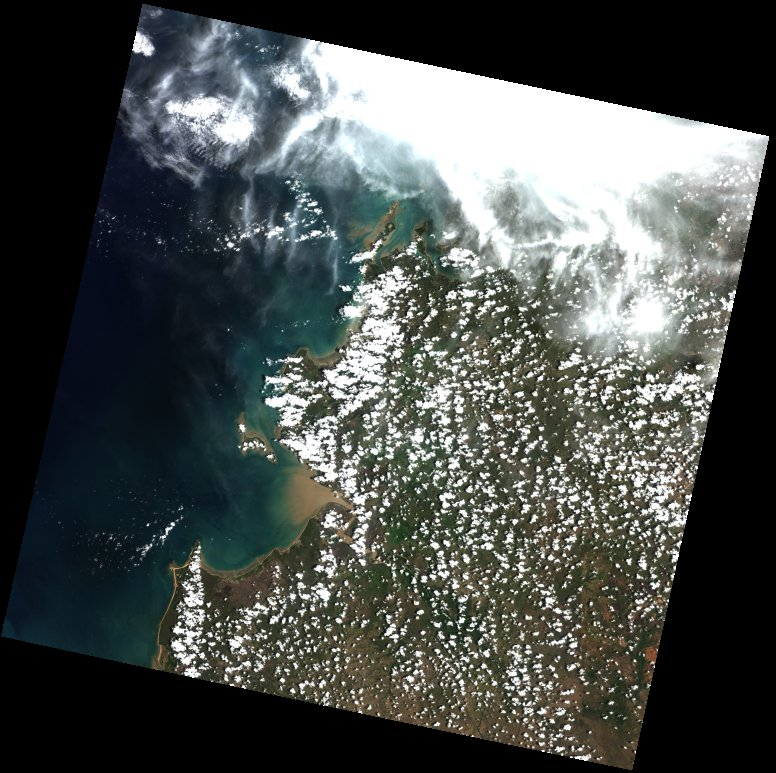

index: 13  Image: ga_ls8c_nbart_3-2-1_106069_2021-12-05_final_thumbnail.jpg


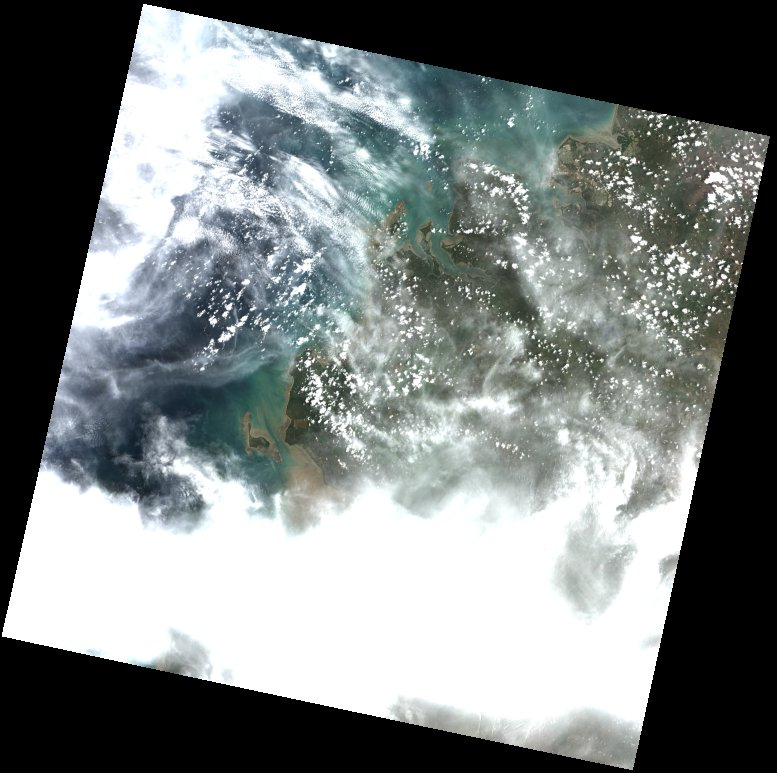

index: 14  Image: ga_ls8c_nbart_3-2-1_106069_2021-12-21_final_thumbnail.jpg


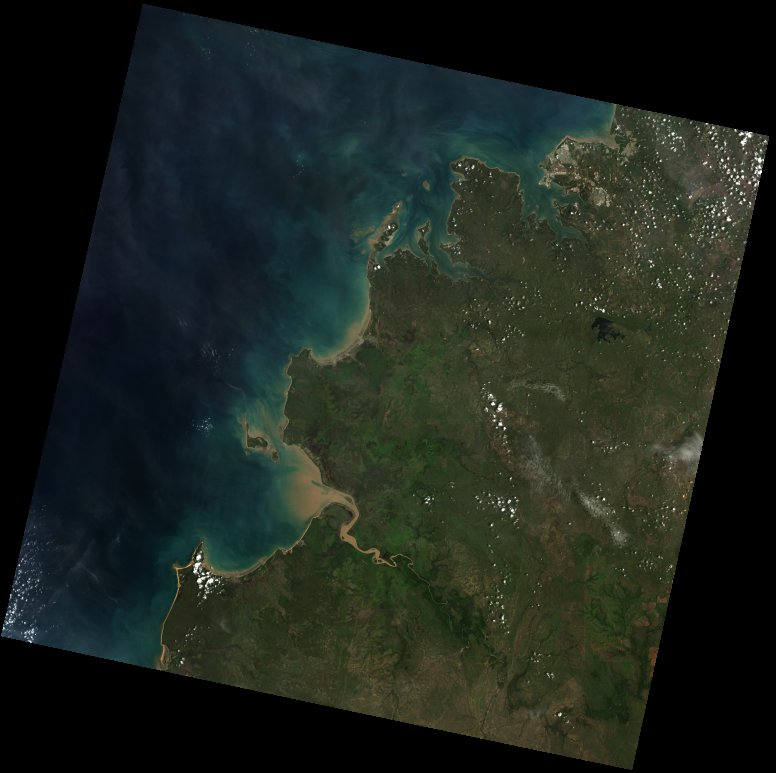

index: 15  Image: ga_ls8c_nbart_3-2-1_106069_2022-01-06_final_thumbnail.jpg


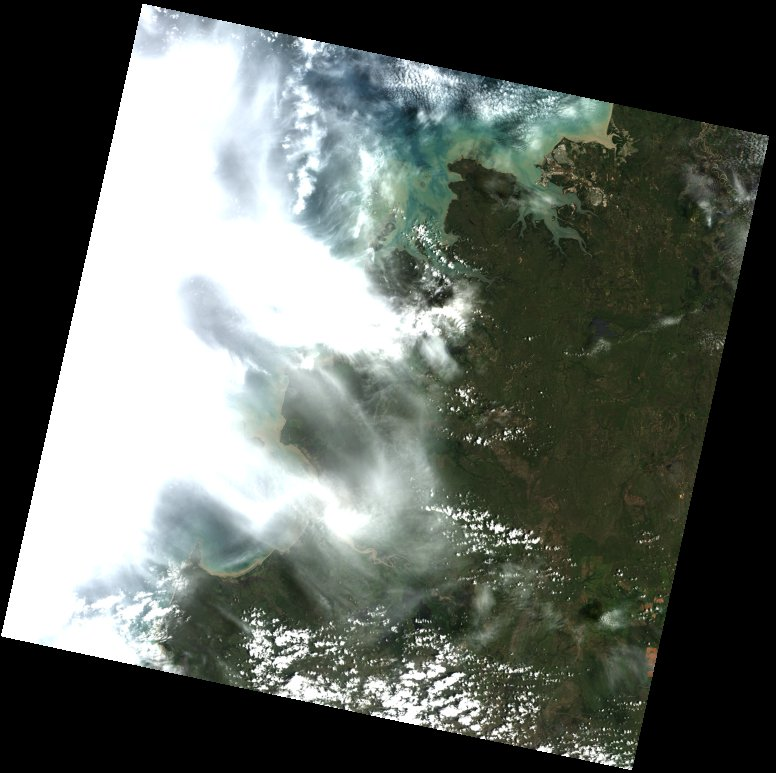

index: 16  Image: ga_ls8c_nbart_3-2-1_106069_2022-01-22_final_thumbnail.jpg


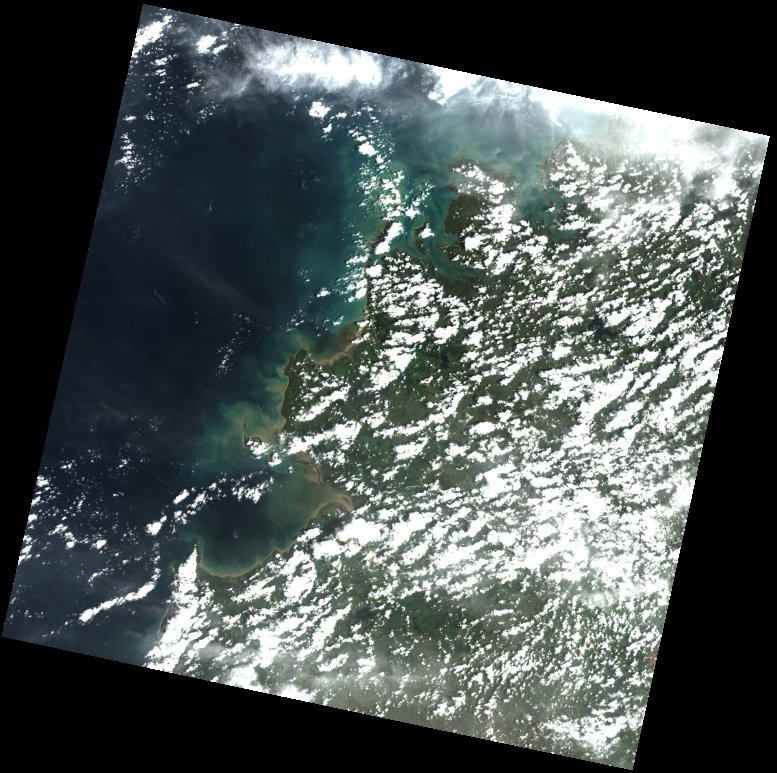

index: 17  Image: ga_ls8c_nbart_3-2-1_106069_2022-02-07_final_thumbnail.jpg


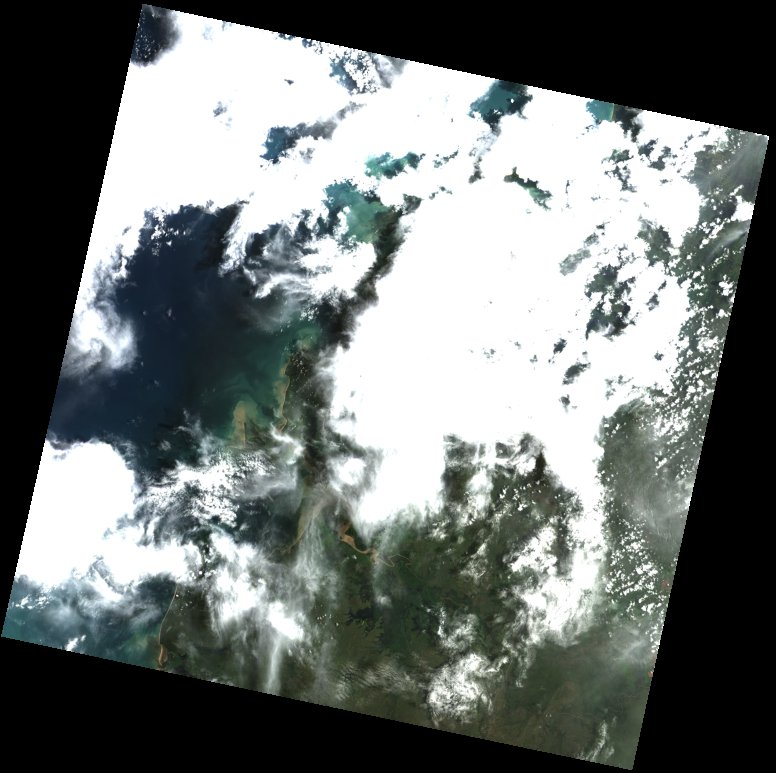

index: 18  Image: ga_ls8c_nbart_3-2-1_106069_2022-02-23_final_thumbnail.jpg


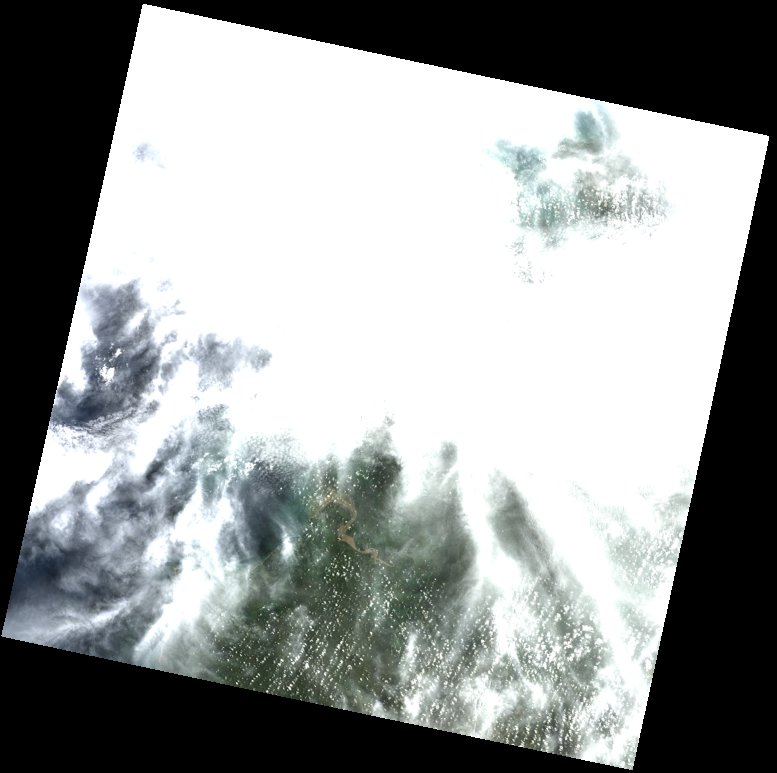

index: 19  Image: ga_ls8c_nbart_3-2-1_106069_2022-03-11_final_thumbnail.jpg


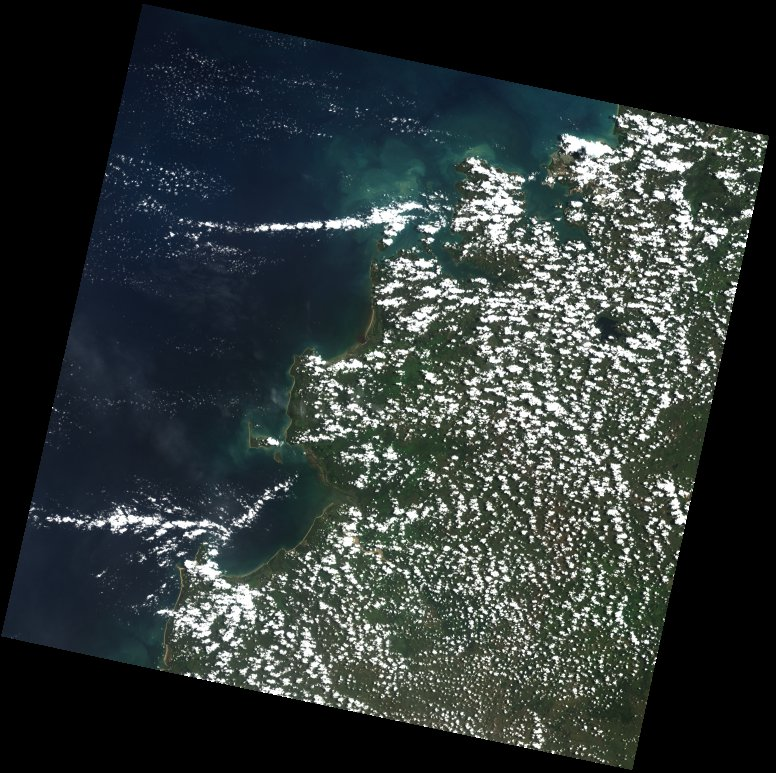

index: 20  Image: ga_ls8c_nbart_3-2-1_106069_2022-03-27_final_thumbnail.jpg


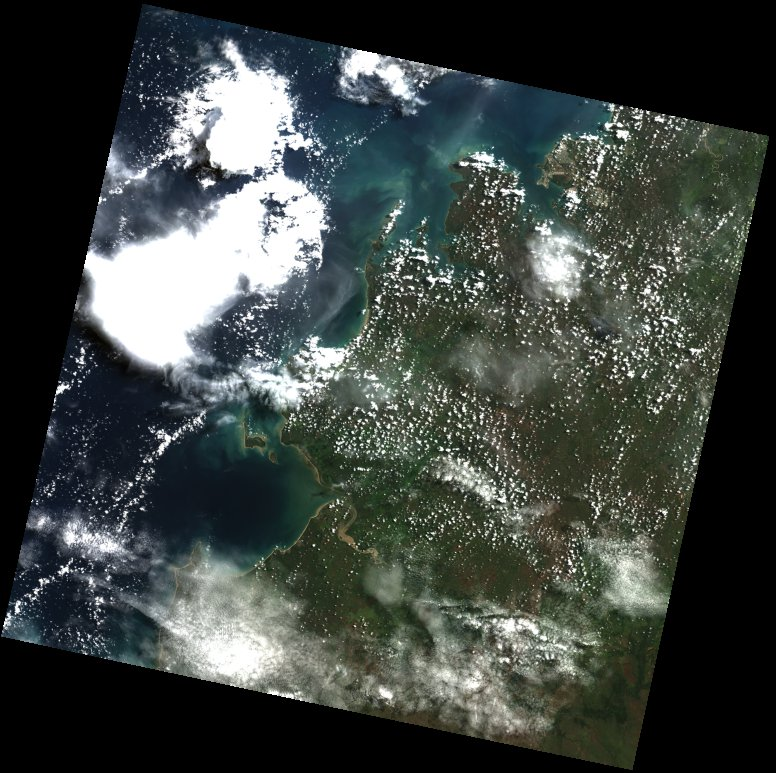

index: 21  Image: ga_ls8c_nbart_3-2-1_106069_2022-04-12_final_thumbnail.jpg


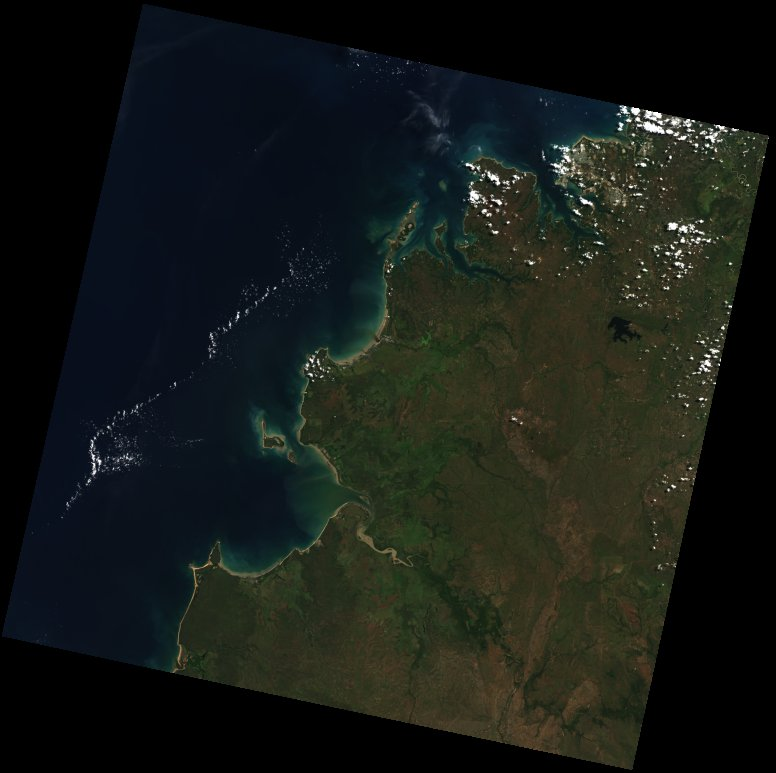

index: 22  Image: ga_ls8c_nbart_3-2-1_106069_2022-04-28_final_thumbnail.jpg


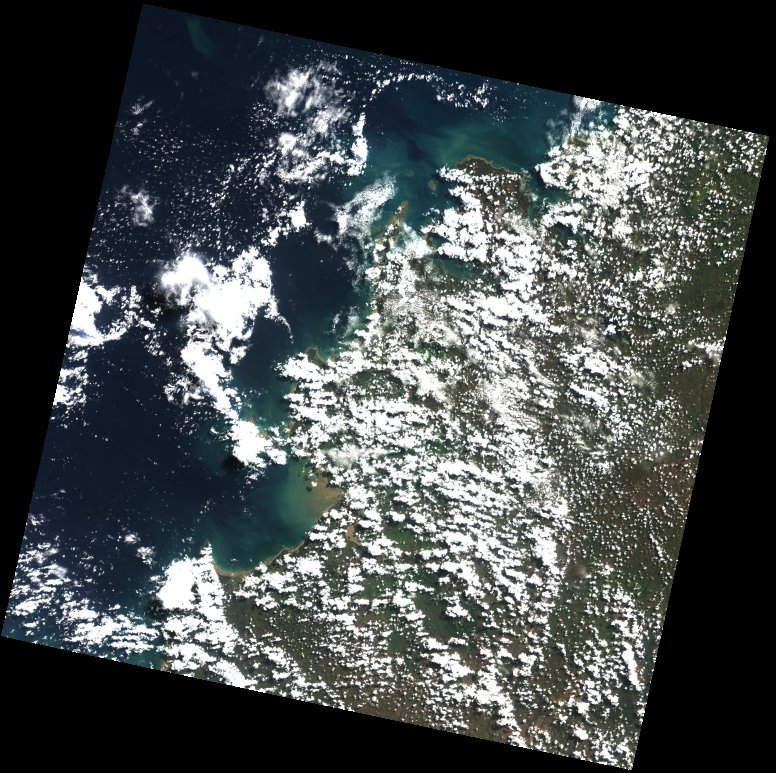

index: 23  Image: ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_thumbnail.jpg


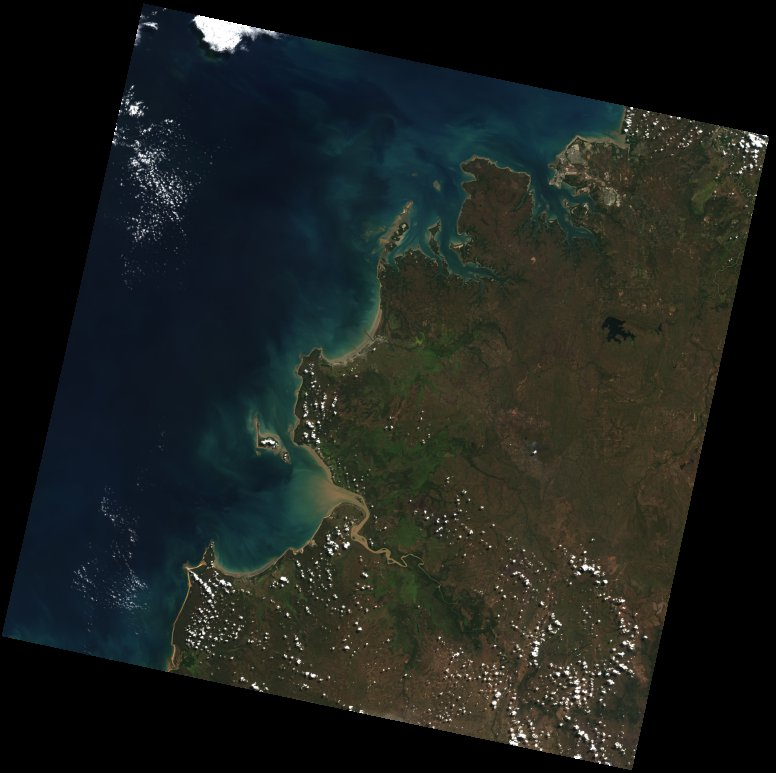

index: 24  Image: ga_ls8c_nbart_3-2-1_106069_2022-05-30_final_thumbnail.jpg


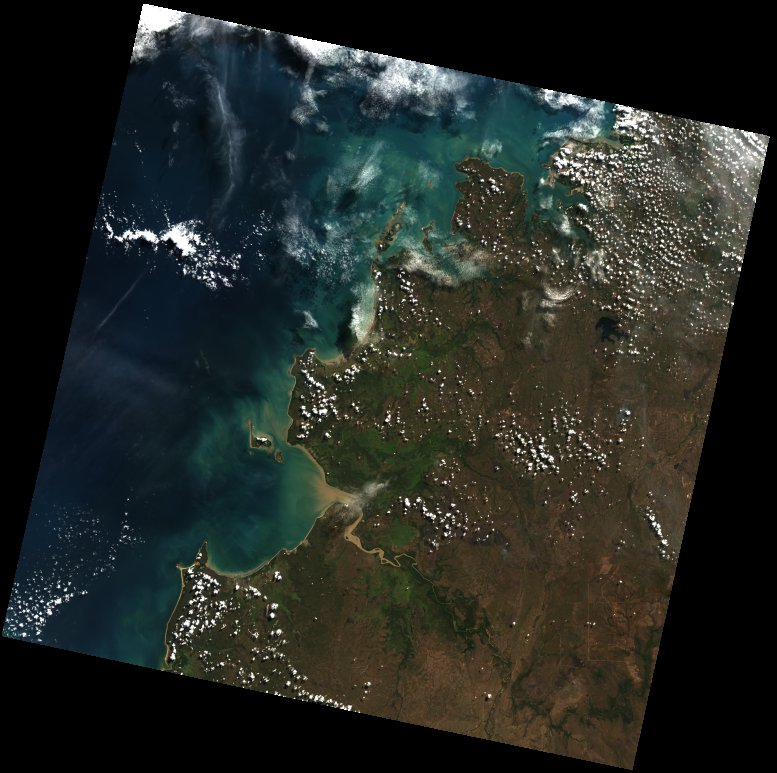

index: 25  Image: ga_ls8c_nbart_3-2-1_106069_2022-06-15_final_thumbnail.jpg


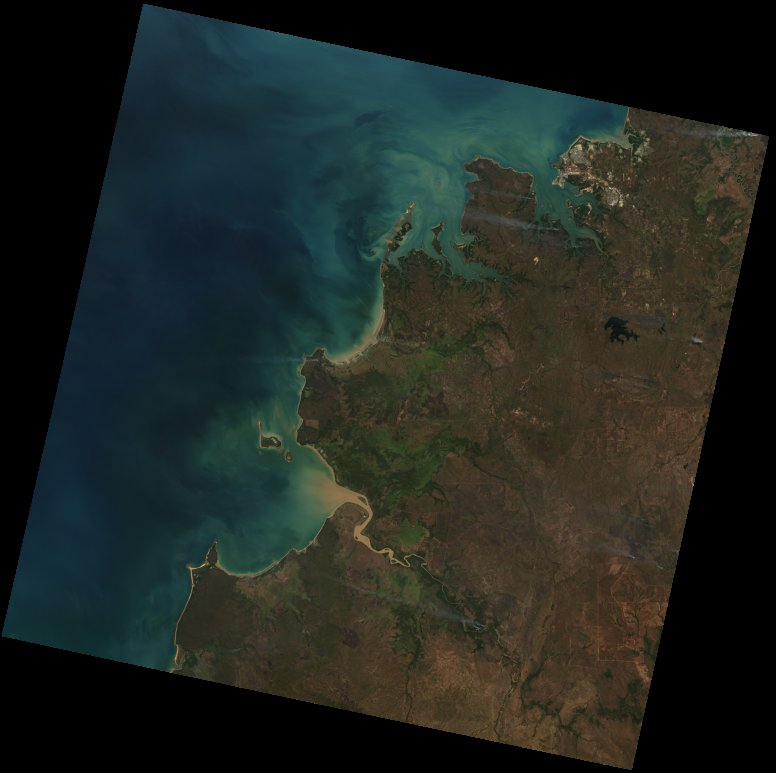

index: 26  Image: ga_ls8c_nbart_3-2-1_106069_2022-07-01_final_thumbnail.jpg


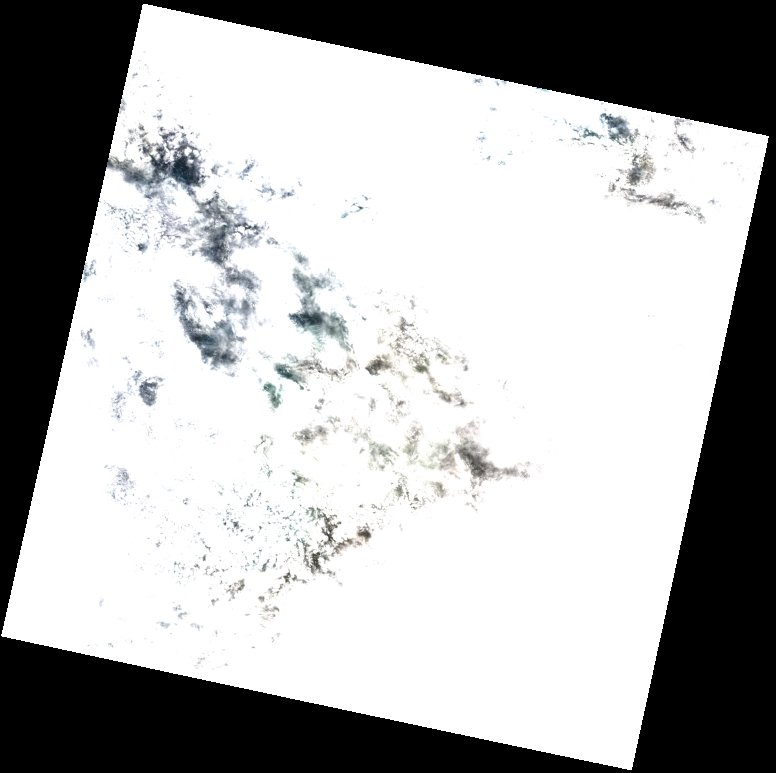

index: 27  Image: ga_ls8c_nbart_3-2-1_106069_2022-07-17_final_thumbnail.jpg


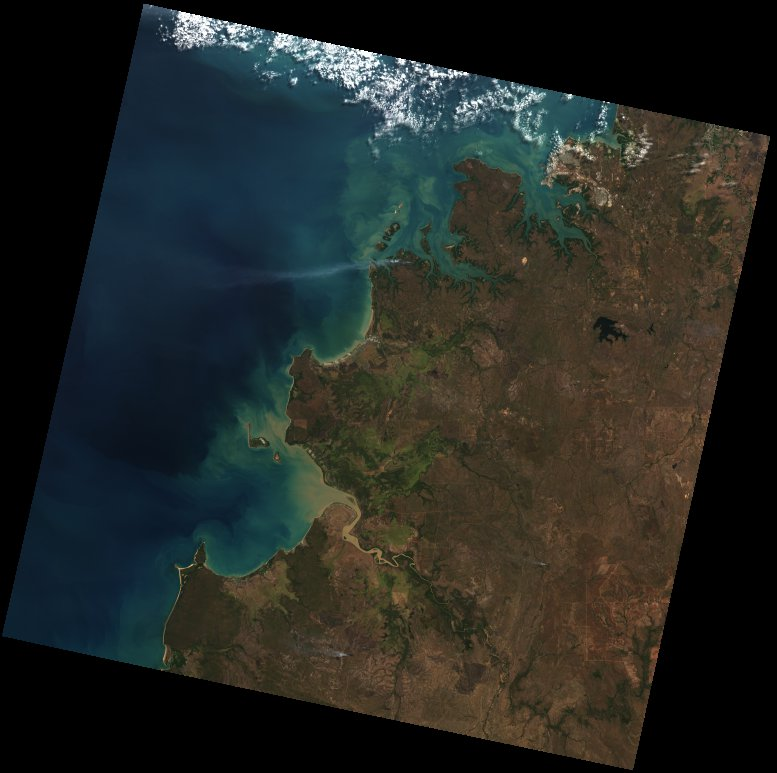

index: 28  Image: ga_ls8c_nbart_3-2-1_106069_2022-08-02_final_thumbnail.jpg


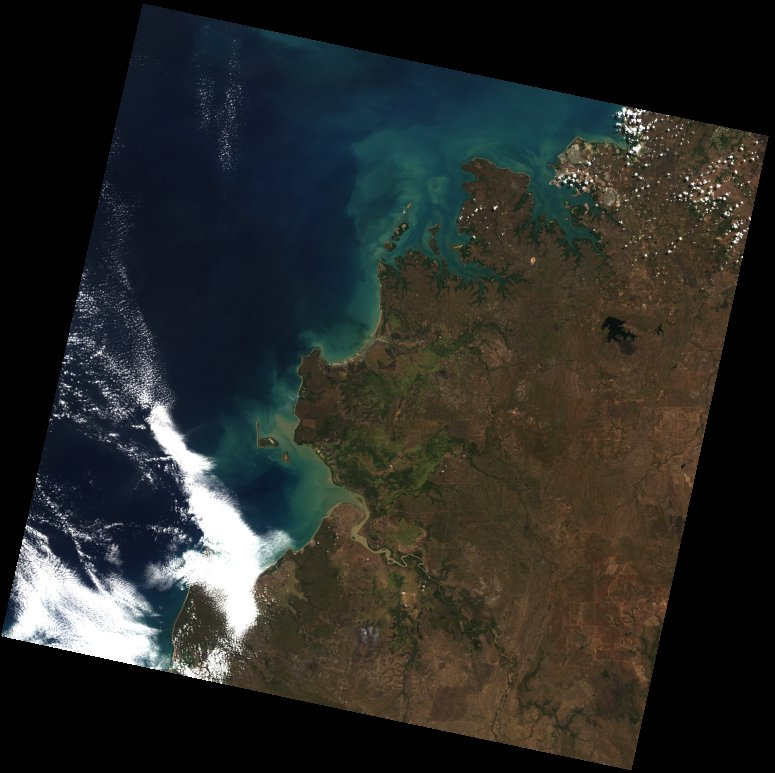

index: 29  Image: ga_ls8c_nbart_3-2-1_106069_2022-08-18_final_thumbnail.jpg


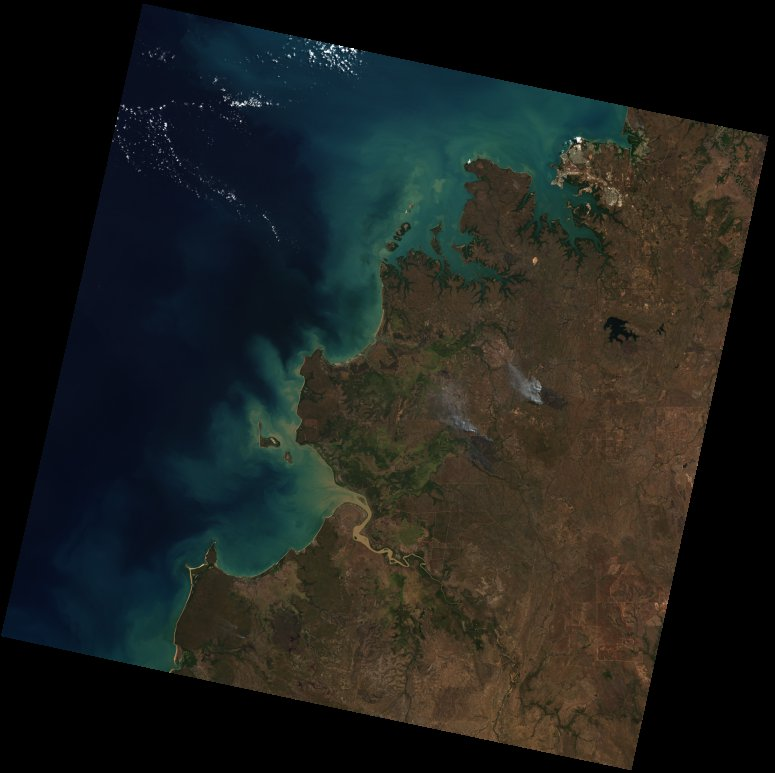

index: 30  Image: ga_ls8c_nbart_3-2-1_106069_2022-09-03_final_thumbnail.jpg


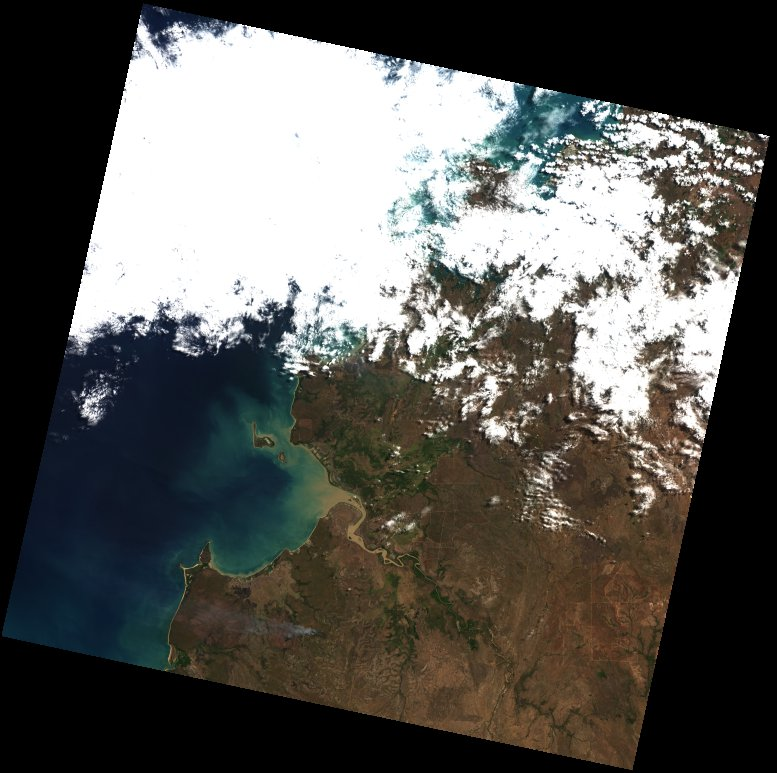

index: 31  Image: ga_ls8c_nbart_3-2-1_106069_2022-09-19_final_thumbnail.jpg


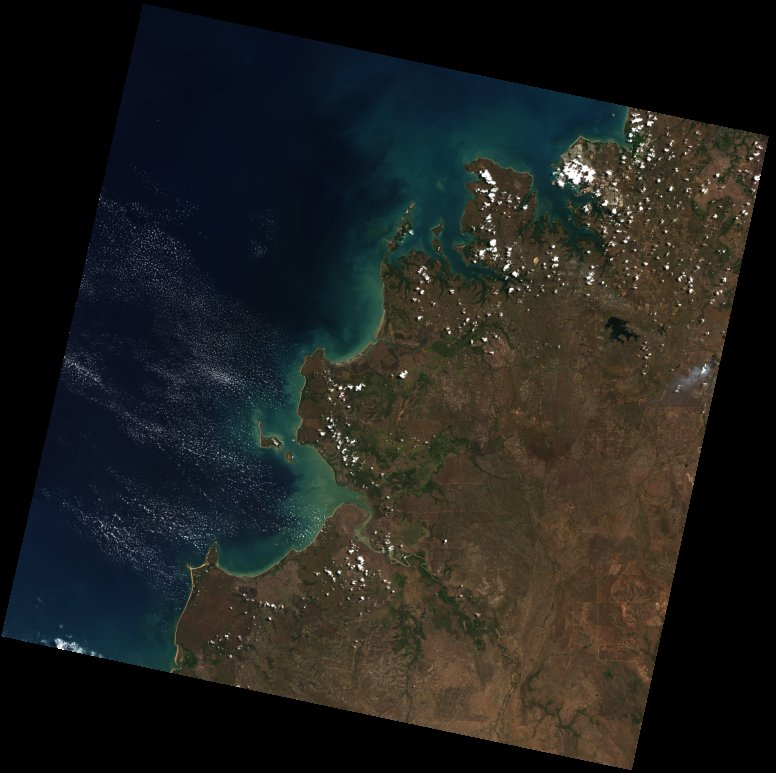

index: 32  Image: ga_ls8c_nbart_3-2-1_106069_2022-10-05_final_thumbnail.jpg


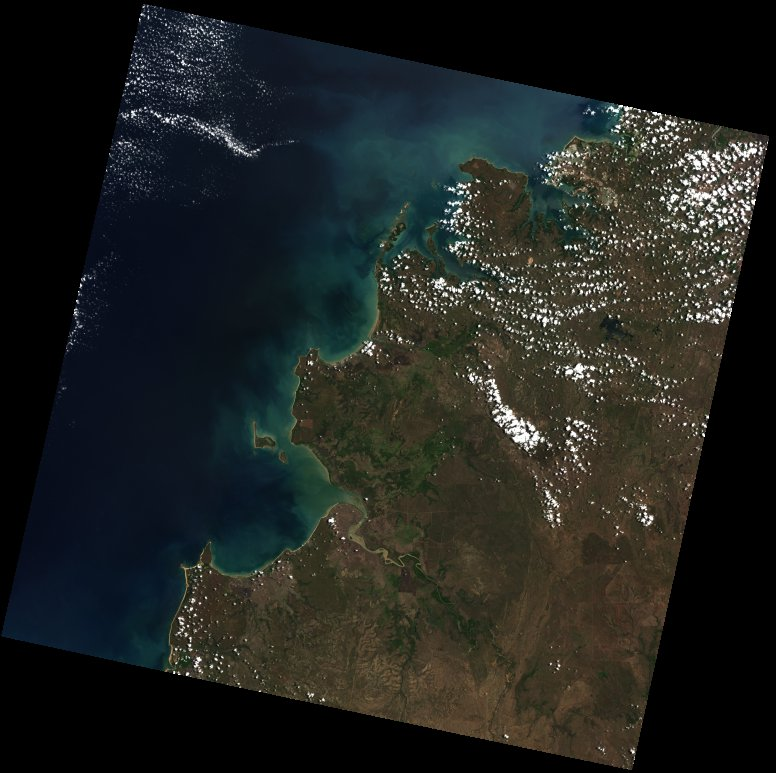

index: 33  Image: ga_ls8c_nbart_3-2-1_106069_2022-10-21_final_thumbnail.jpg


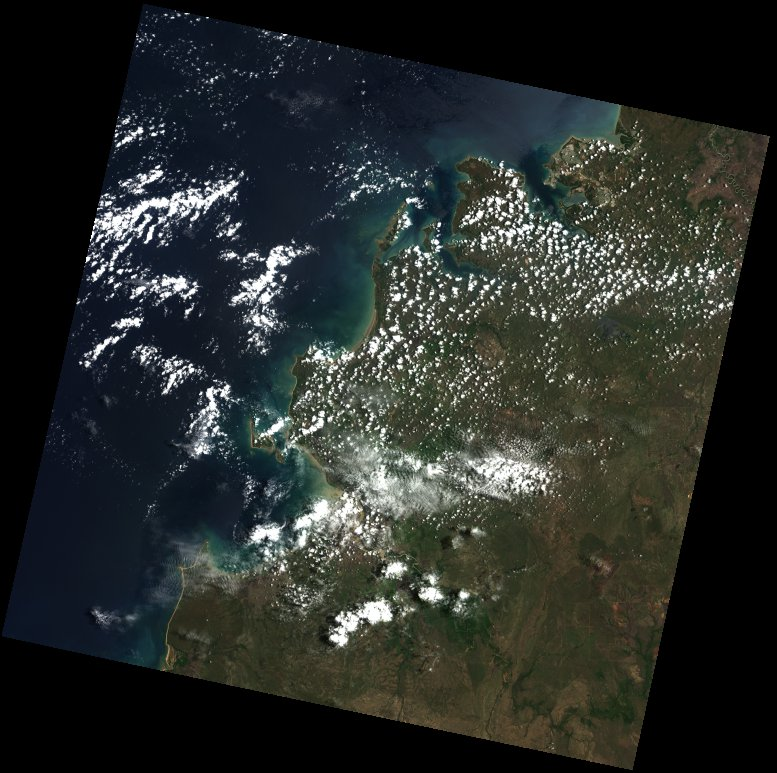

index: 34  Image: ga_ls8c_nbart_3-2-1_106069_2022-11-06_final_thumbnail.jpg


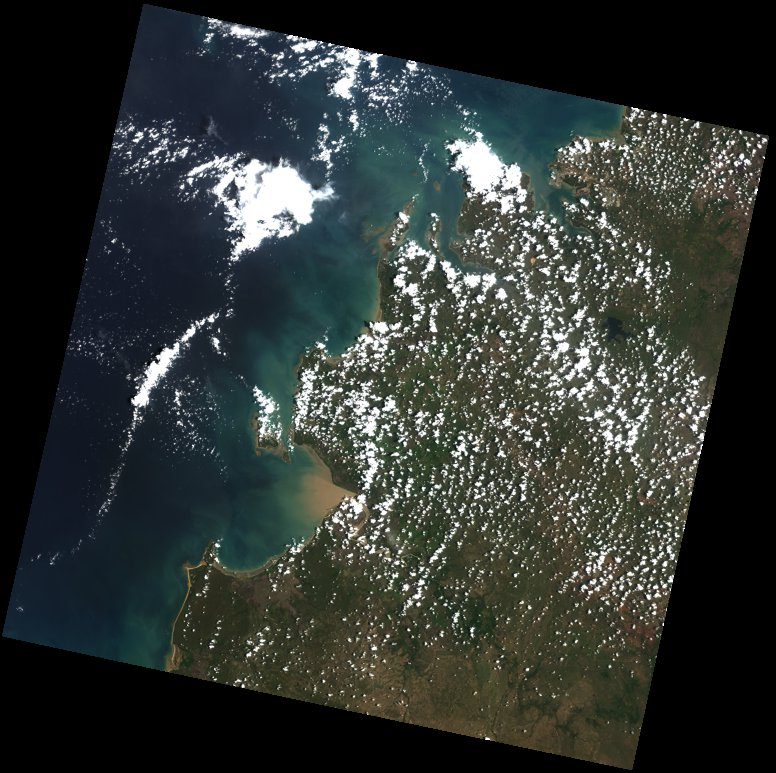

index: 35  Image: ga_ls8c_nbart_3-2-1_106069_2022-11-22_final_thumbnail.jpg


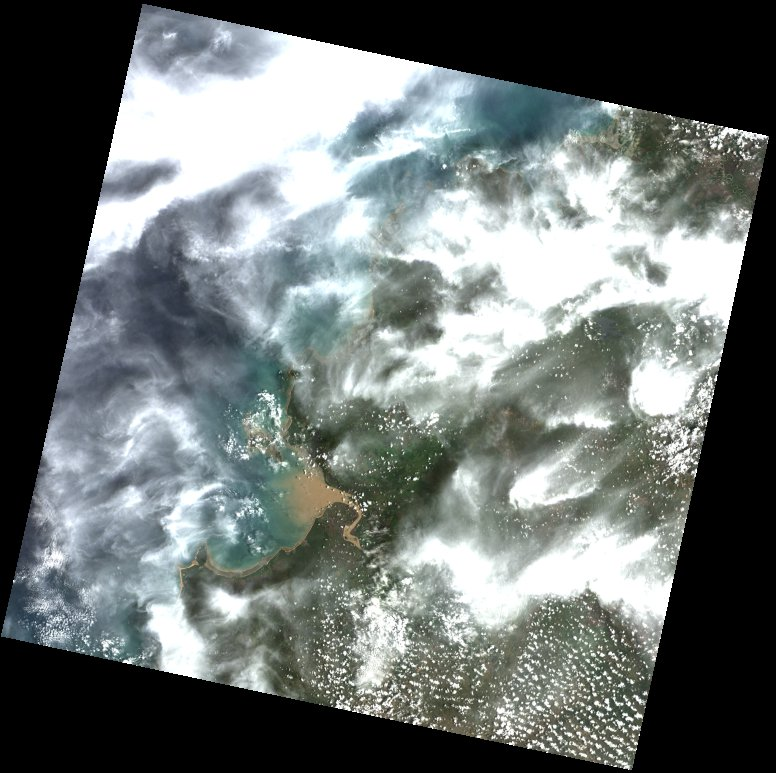

index: 36  Image: ga_ls8c_nbart_3-2-1_106069_2022-12-08_final_thumbnail.jpg


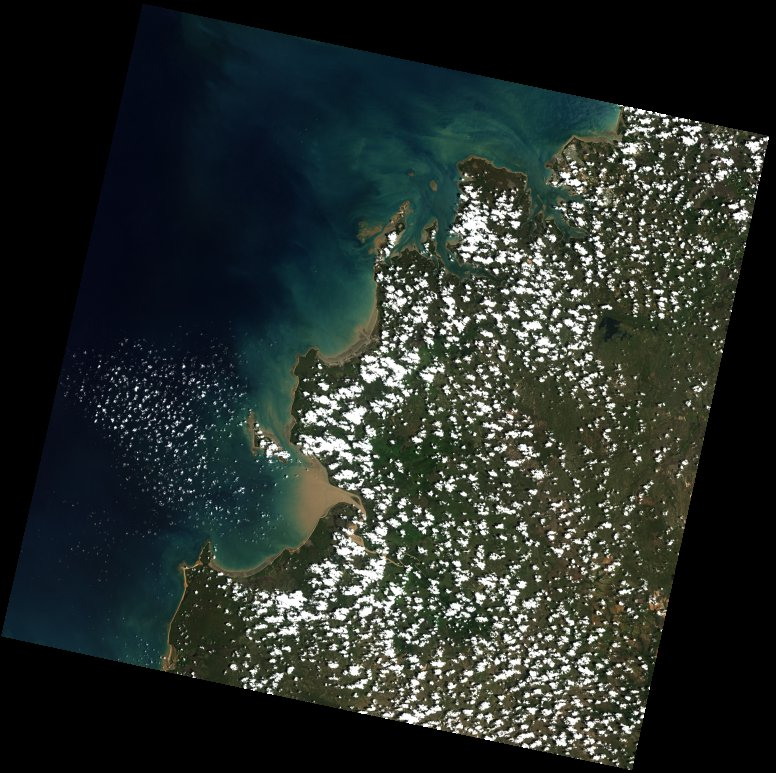

index: 37  Image: ga_ls8c_nbart_3-2-1_106069_2022-12-24_final_thumbnail.jpg


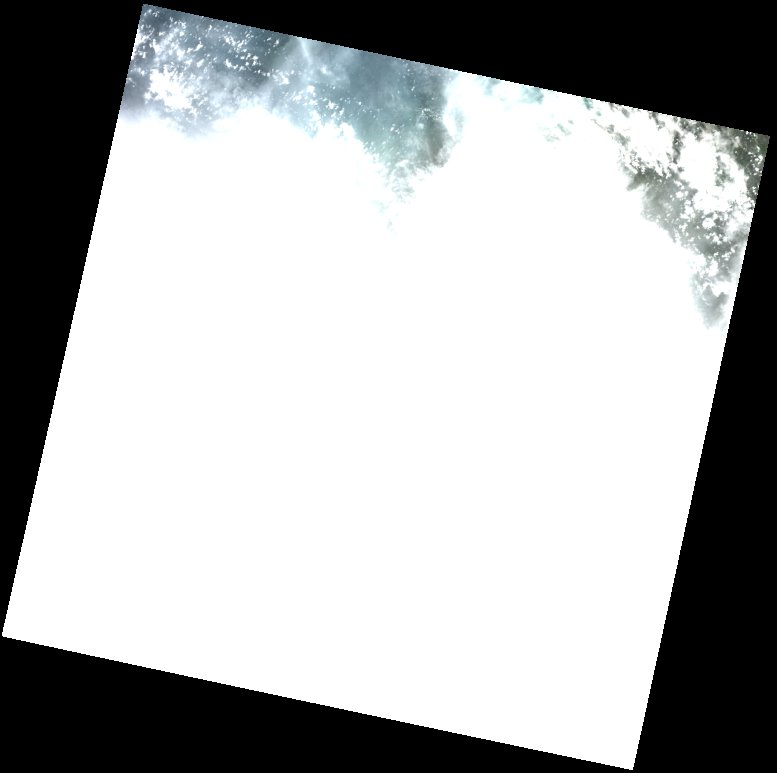

index: 38  Image: ga_ls8c_nbart_3-2-1_106069_2023-01-09_final_thumbnail.jpg


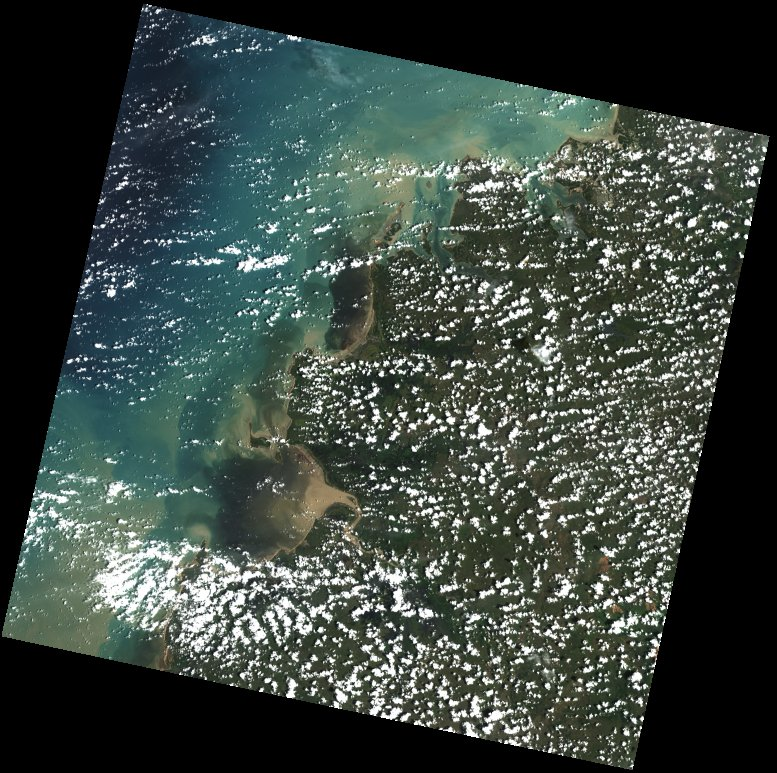

index: 39  Image: ga_ls8c_nbart_3-2-1_106069_2023-01-25_final_thumbnail.jpg


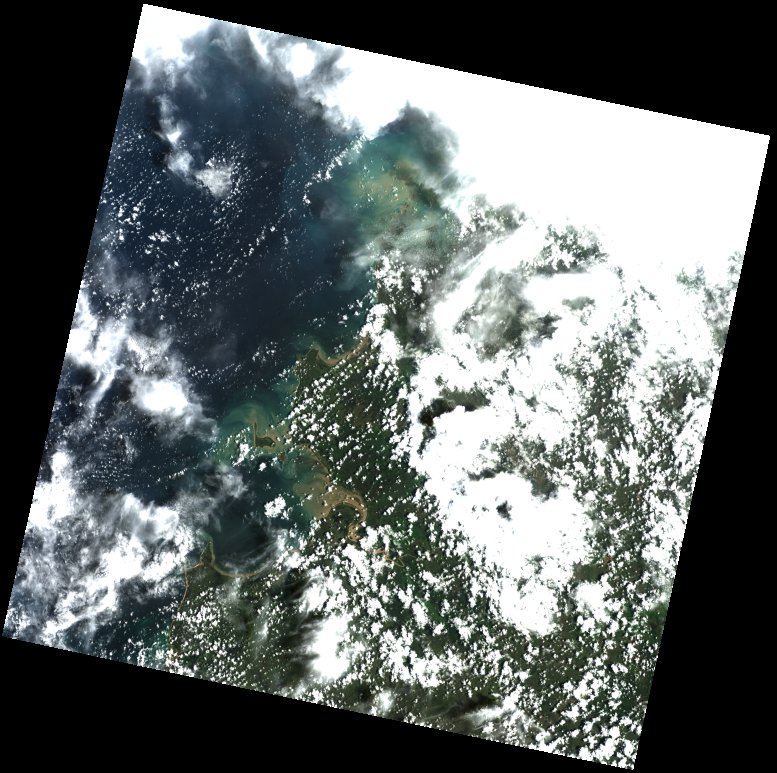

index: 40  Image: ga_ls8c_nbart_3-2-1_106069_2023-02-10_final_thumbnail.jpg


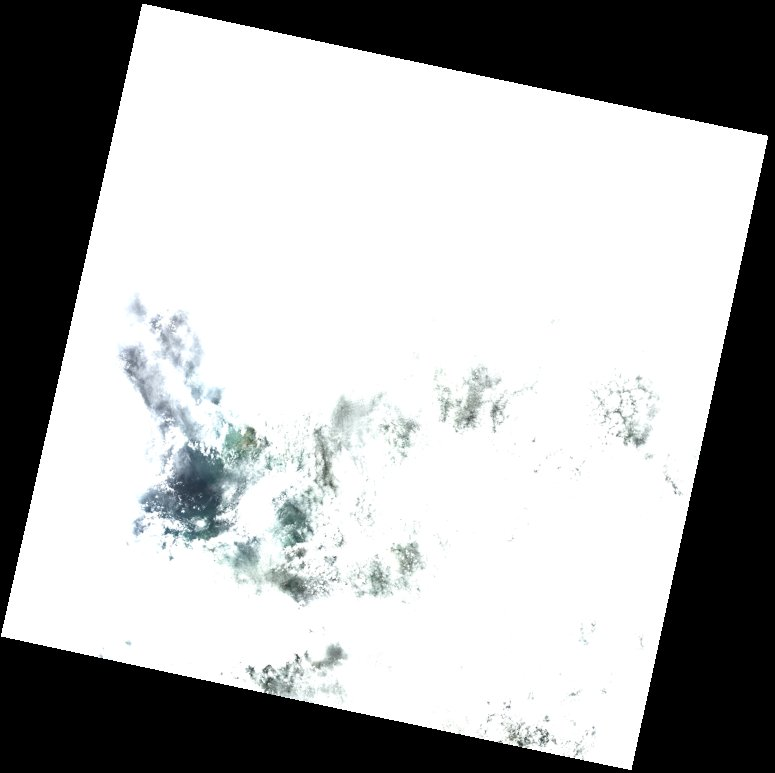

index: 41  Image: ga_ls8c_nbart_3-2-1_106069_2023-02-26_final_thumbnail.jpg


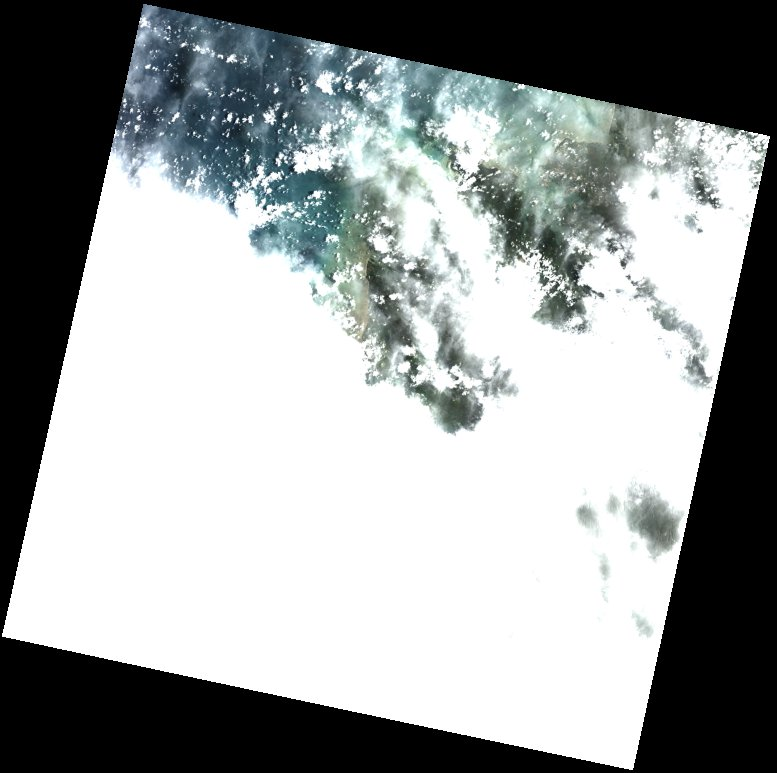

index: 42  Image: ga_ls8c_nbart_3-2-1_106069_2023-03-14_final_thumbnail.jpg


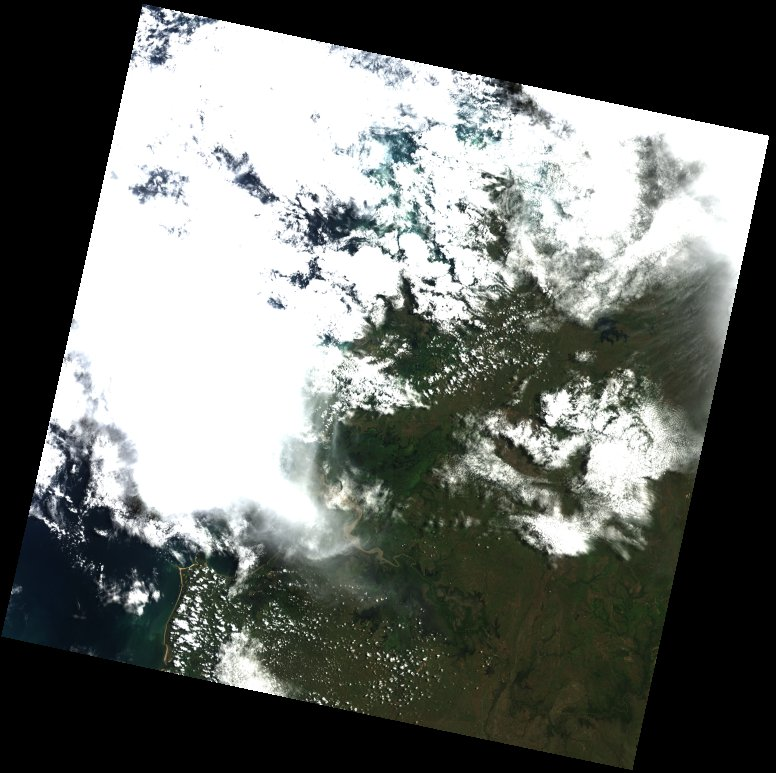

index: 43  Image: ga_ls8c_nbart_3-2-1_106069_2023-03-30_final_thumbnail.jpg


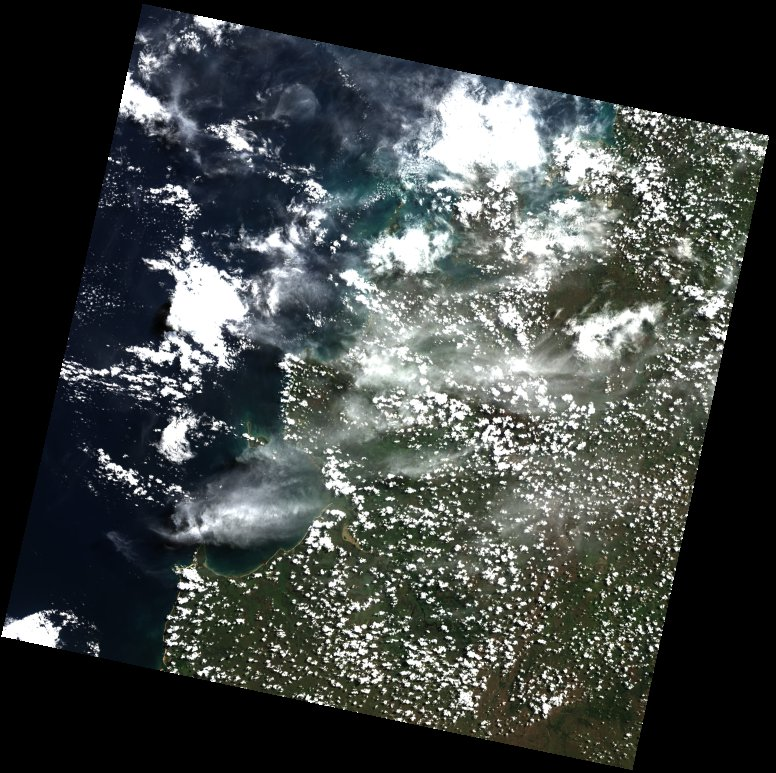

index: 44  Image: ga_ls8c_nbart_3-2-1_106069_2023-04-15_final_thumbnail.jpg


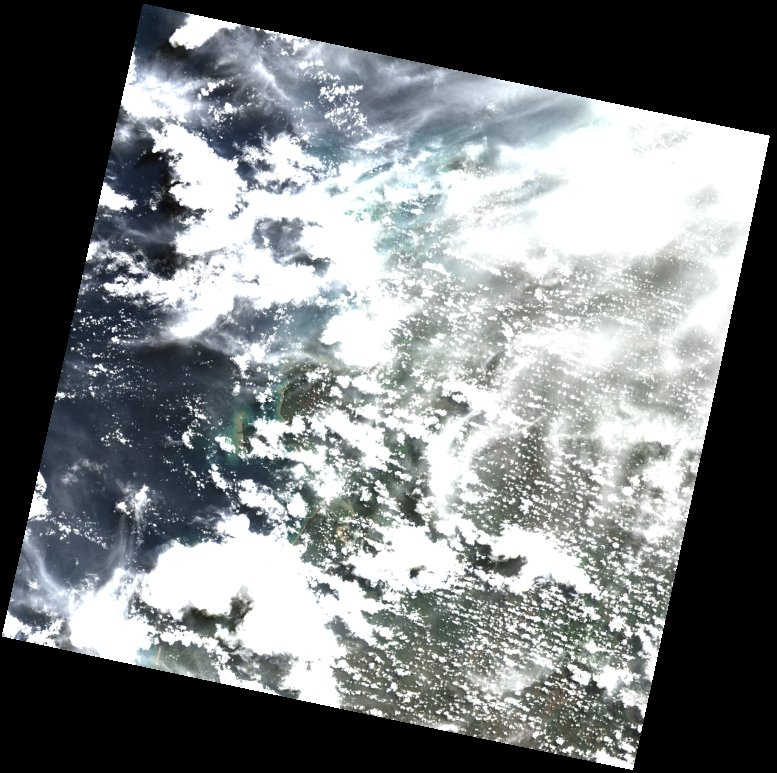

index: 45  Image: ga_ls8c_nbart_3-2-1_106069_2023-05-01_final_thumbnail.jpg


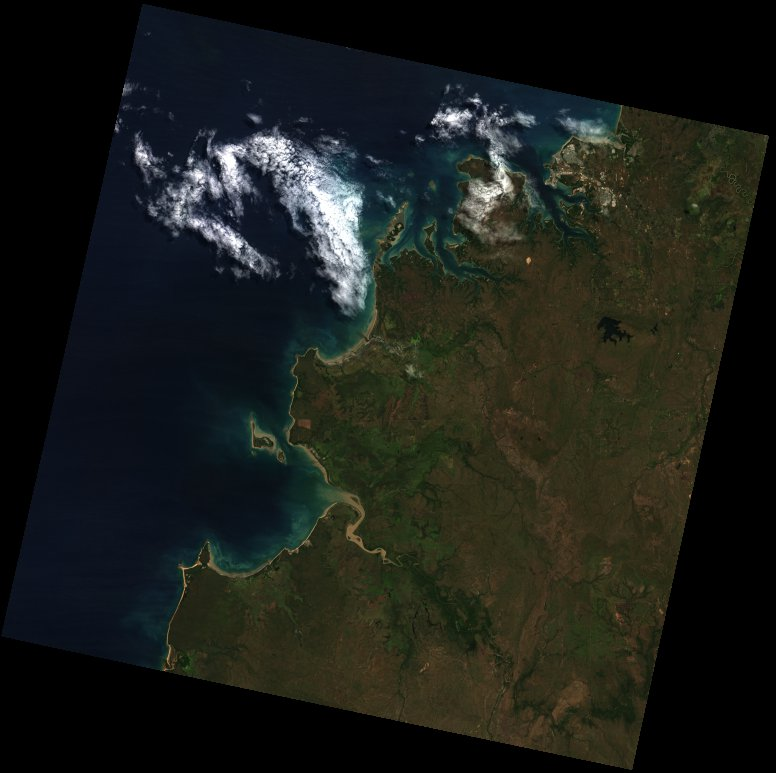

index: 46  Image: ga_ls8c_nbart_3-2-1_106069_2023-05-17_final_thumbnail.jpg


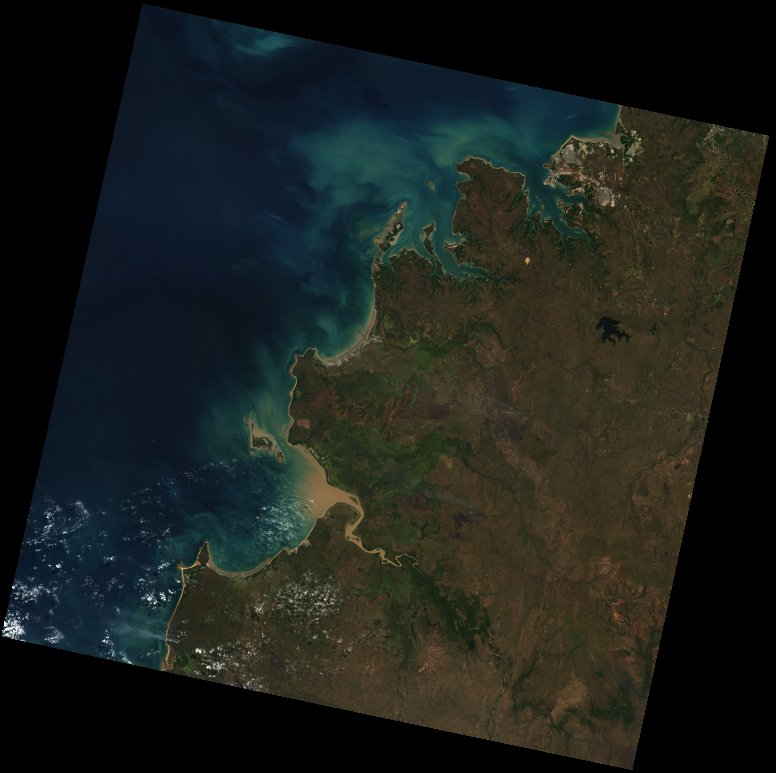

index: 47  Image: ga_ls8c_nbart_3-2-1_106069_2023-06-02_final_thumbnail.jpg


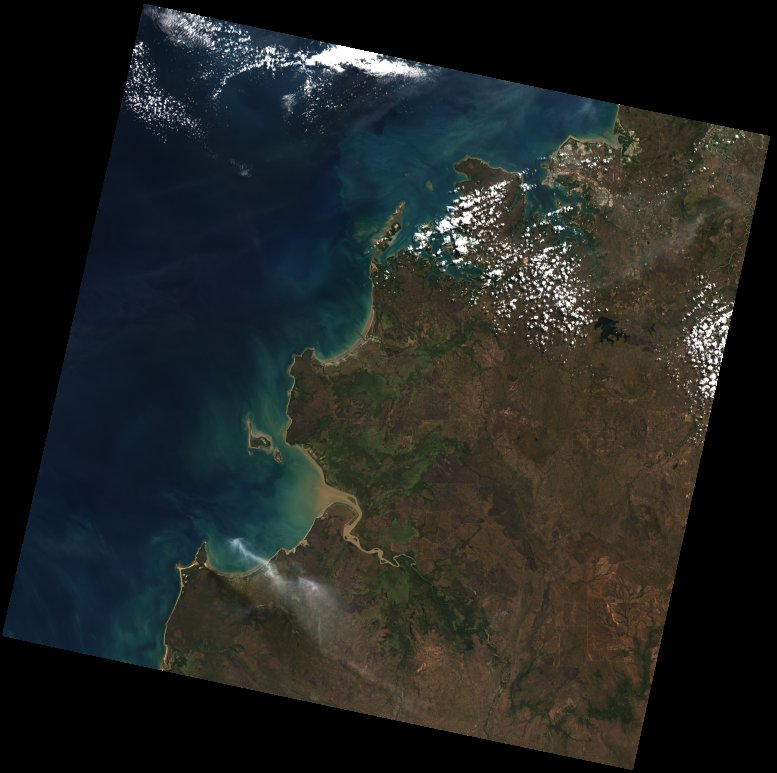

index: 48  Image: ga_ls8c_nbart_3-2-1_106069_2023-06-18_final_thumbnail.jpg


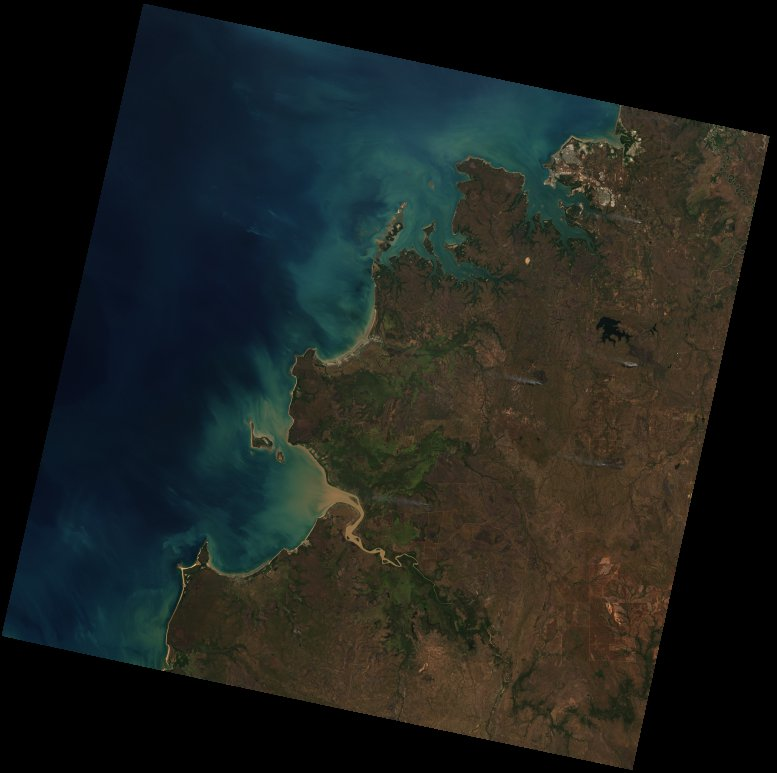

index: 49  Image: ga_ls8c_nbart_3-2-1_106069_2023-07-04_final_thumbnail.jpg


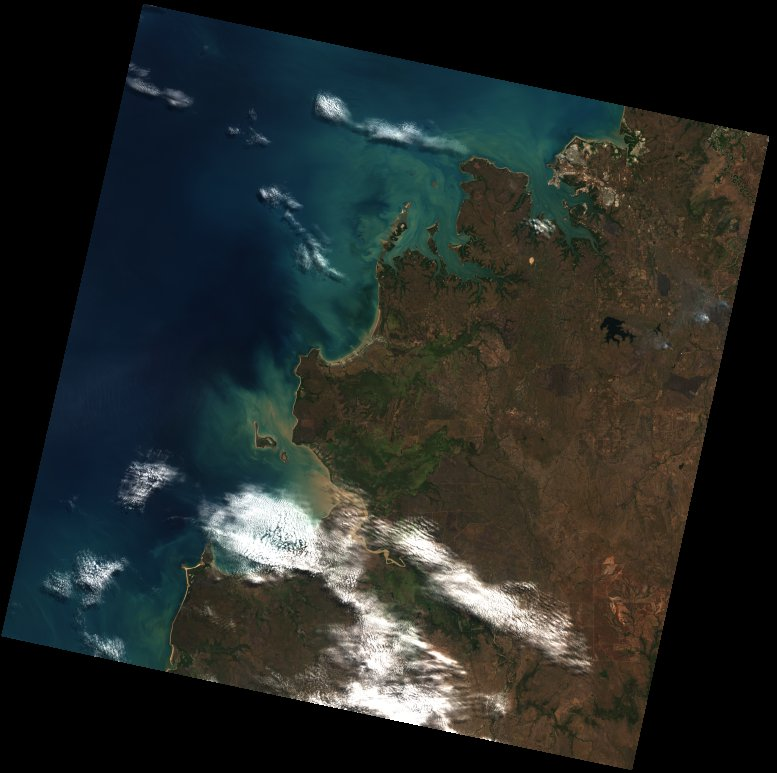

index: 50  Image: ga_ls8c_nbart_3-2-1_106069_2023-07-20_final_thumbnail.jpg


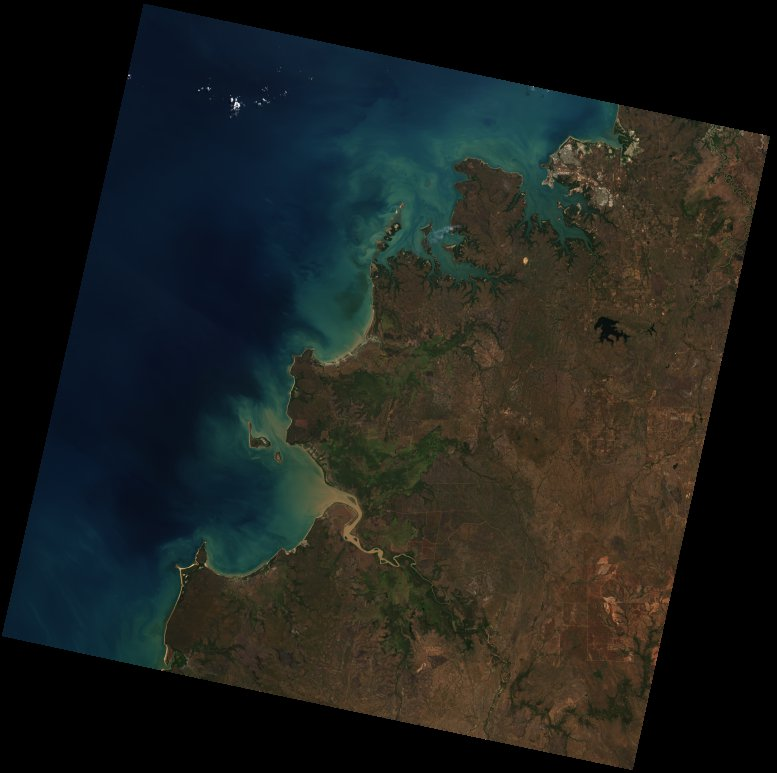

index: 51  Image: ga_ls8c_nbart_3-2-1_106069_2023-08-05_final_thumbnail.jpg


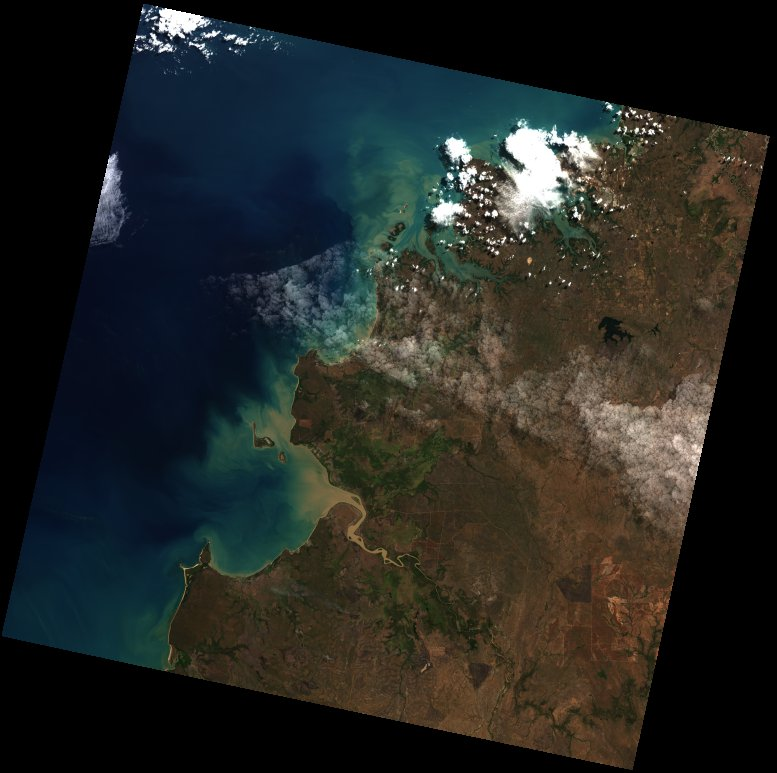

index: 52  Image: ga_ls8c_nbart_3-2-1_106069_2023-08-21_final_thumbnail.jpg


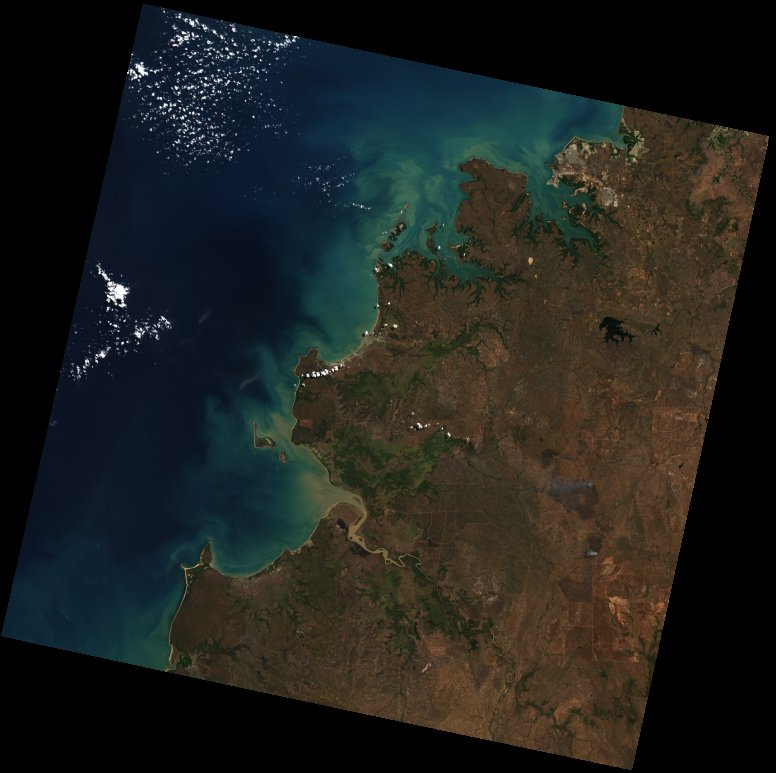

index: 53  Image: ga_ls8c_nbart_3-2-1_106069_2023-09-06_final_thumbnail.jpg


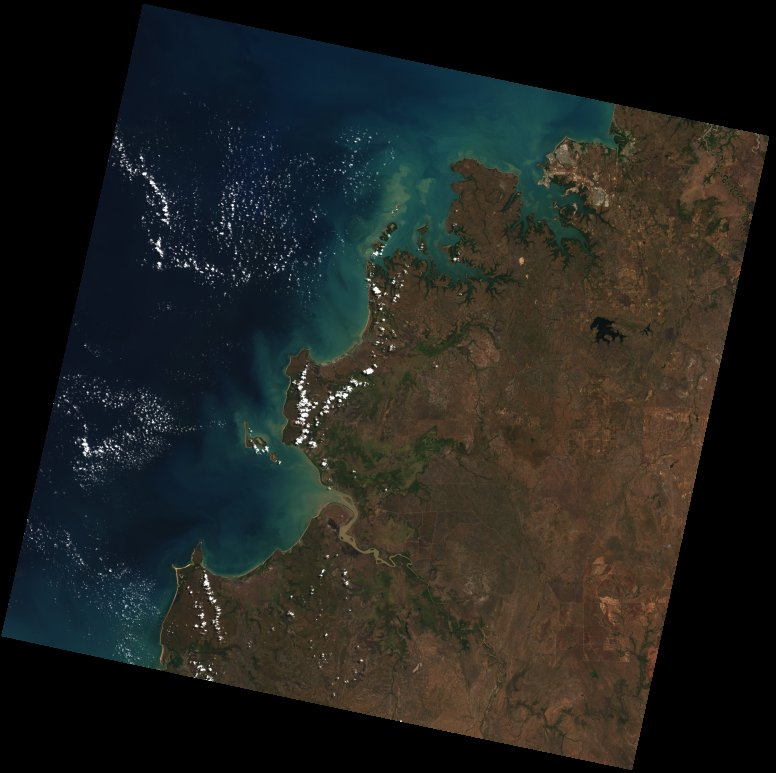

index: 54  Image: ga_ls8c_nbart_3-2-1_106069_2023-09-22_final_thumbnail.jpg


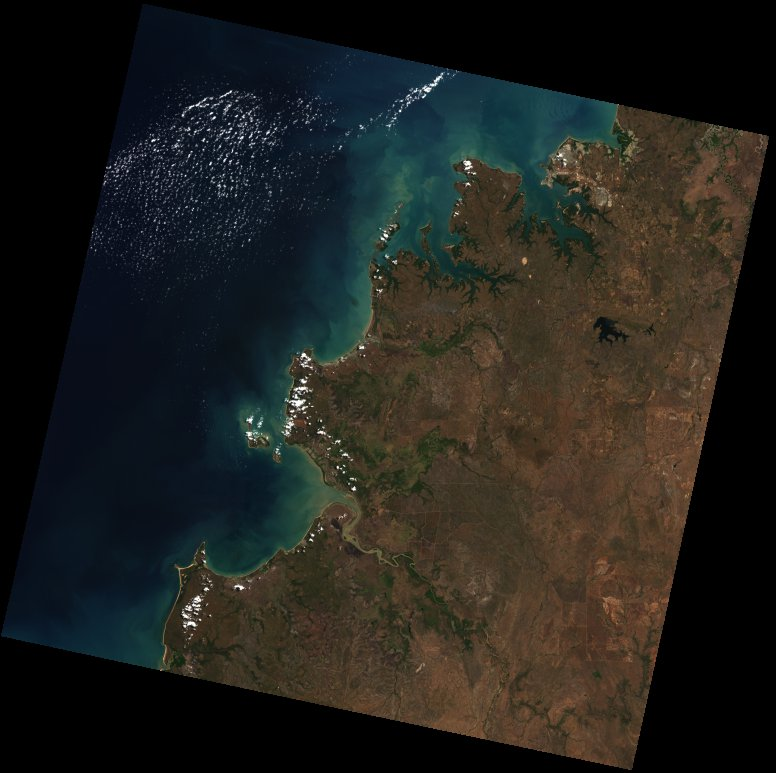

index: 55  Image: ga_ls8c_nbart_3-2-1_106069_2023-10-08_final_thumbnail.jpg


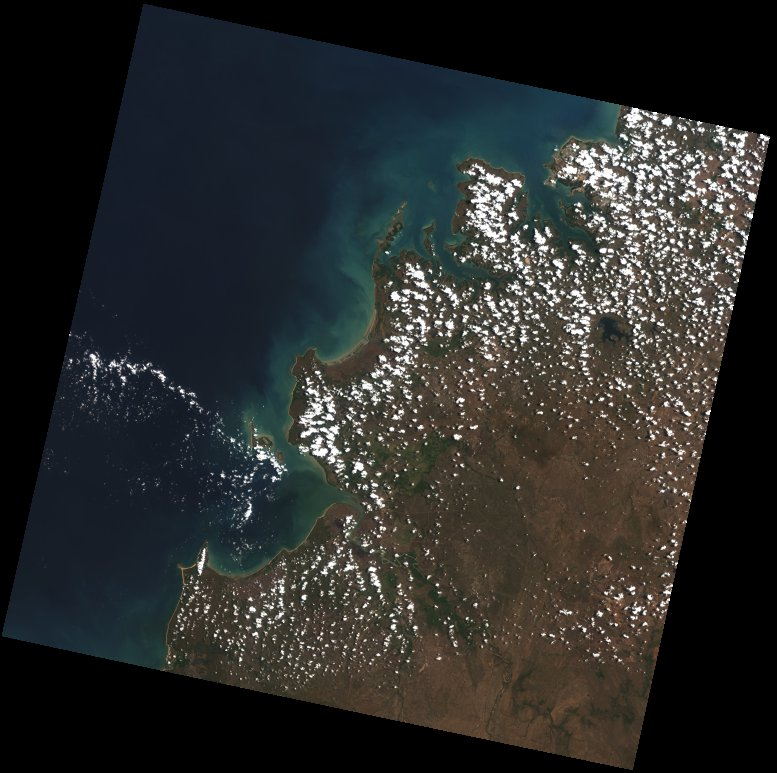

index: 56  Image: ga_ls8c_nbart_3-2-1_106069_2023-10-24_final_thumbnail.jpg


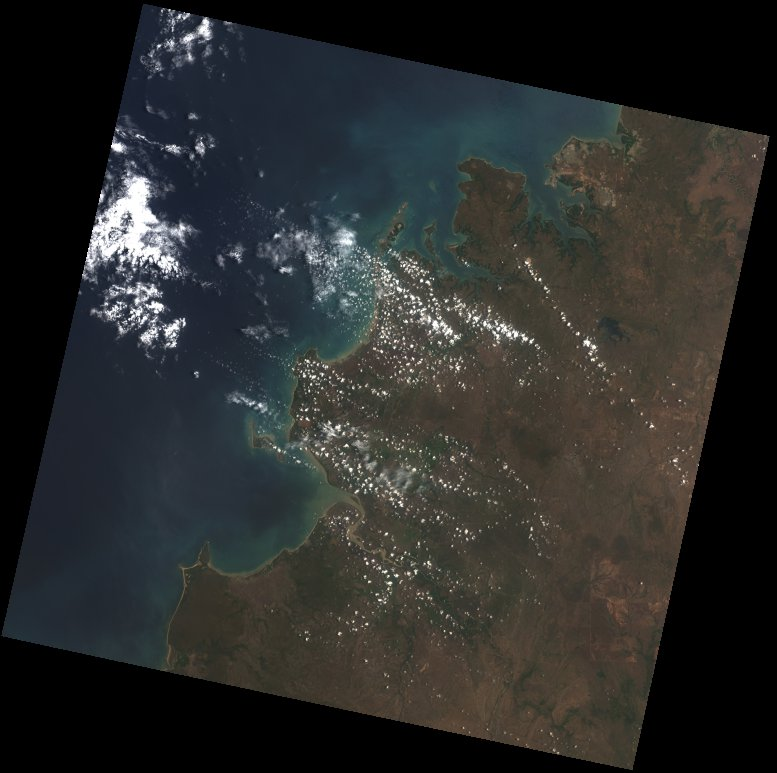

index: 57  Image: ga_ls8c_nbart_3-2-1_106069_2023-11-09_final_thumbnail.jpg


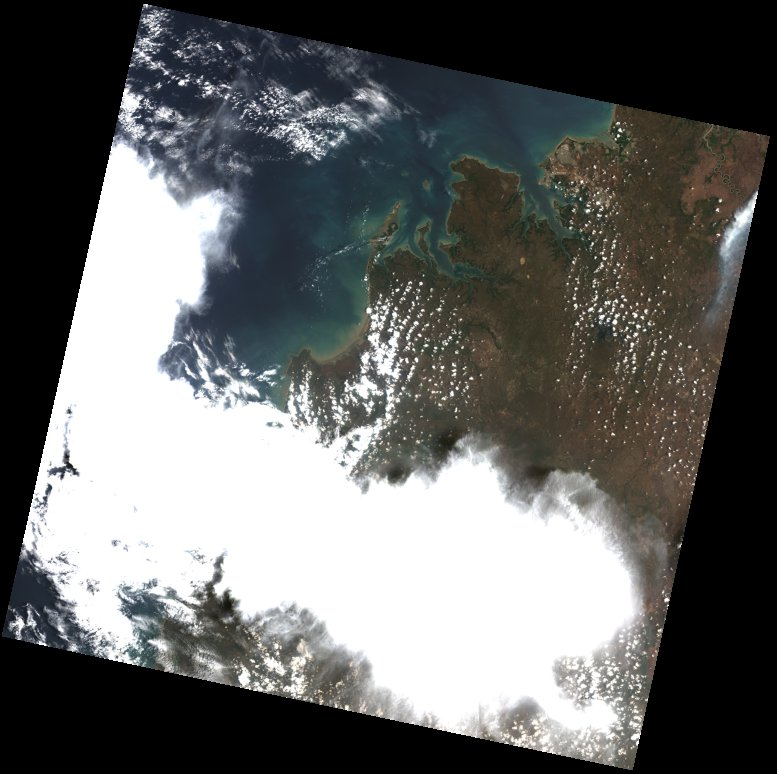

index: 58  Image: ga_ls8c_nbart_3-2-1_106069_2023-11-25_final_thumbnail.jpg


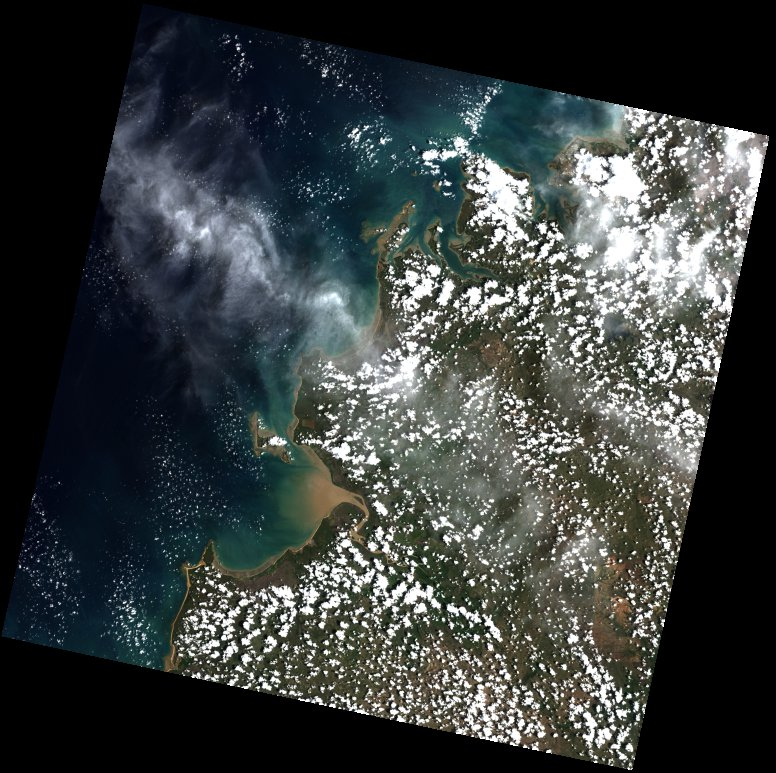

index: 59  Image: ga_ls8c_nbart_3-2-1_106069_2023-12-11_final_thumbnail.jpg


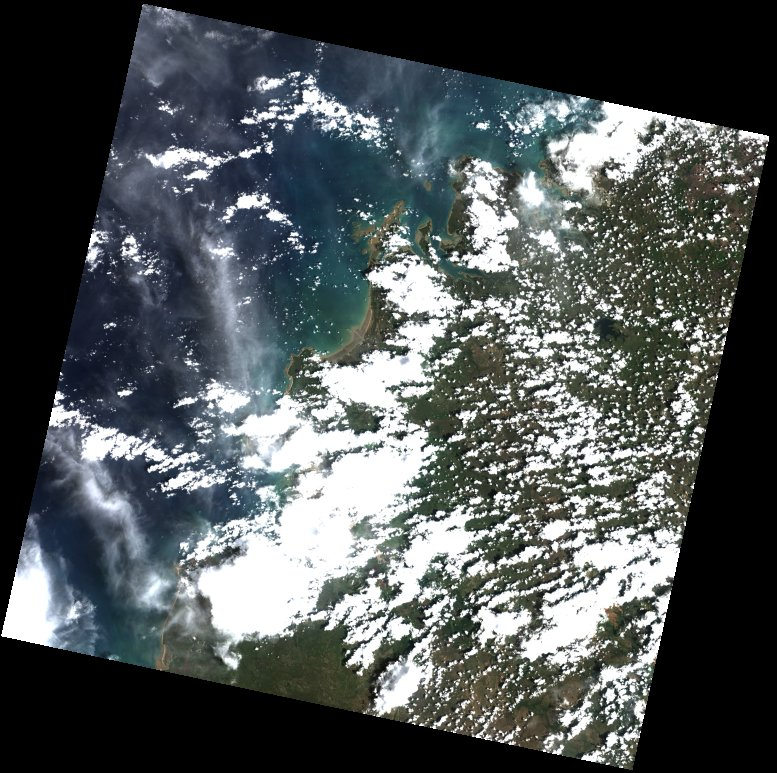

index: 60  Image: ga_ls8c_nbart_3-2-1_106069_2023-12-27_final_thumbnail.jpg


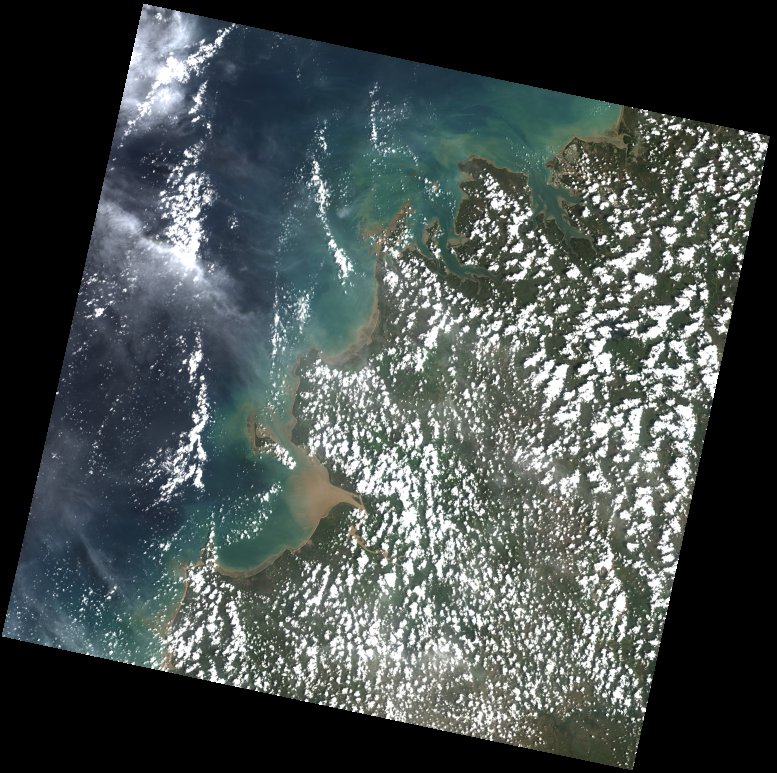

index: 61  Image: ga_ls8c_nbart_3-2-1_106069_2024-01-12_final_thumbnail.jpg


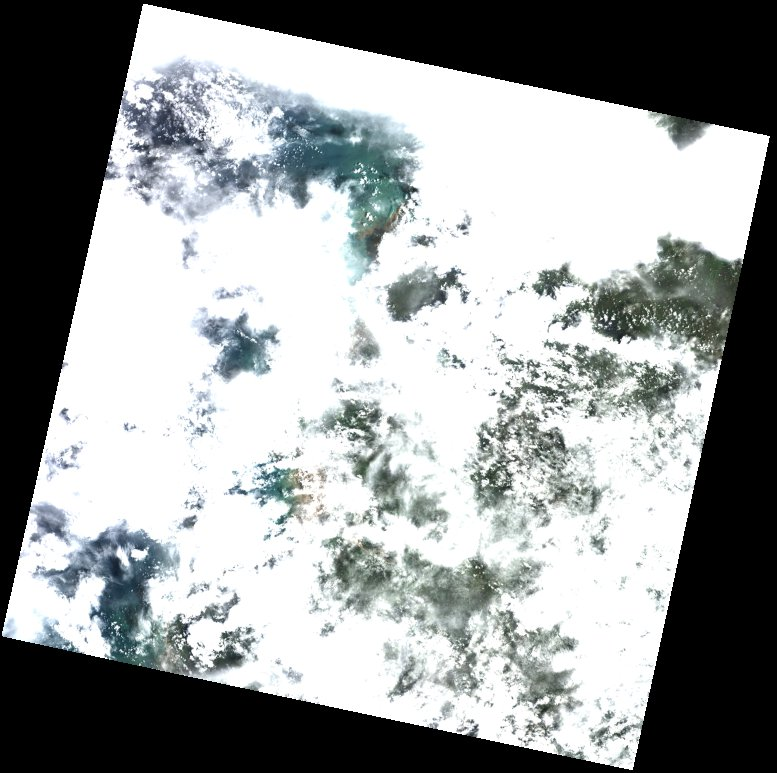

index: 62  Image: ga_ls8c_nbart_3-2-1_106069_2024-01-28_final_thumbnail.jpg


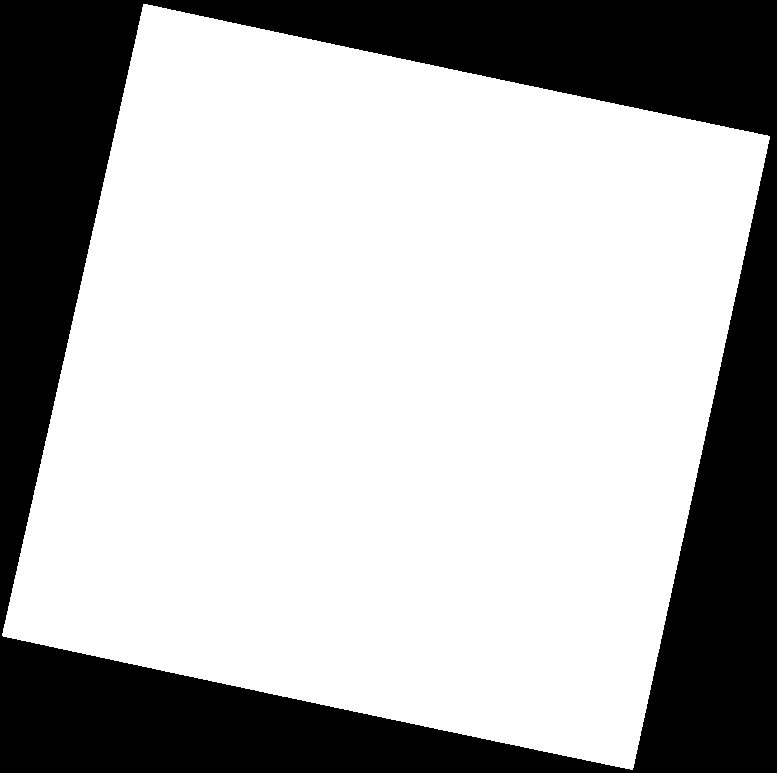

index: 63  Image: ga_ls8c_nbart_3-2-1_106069_2024-02-13_final_thumbnail.jpg


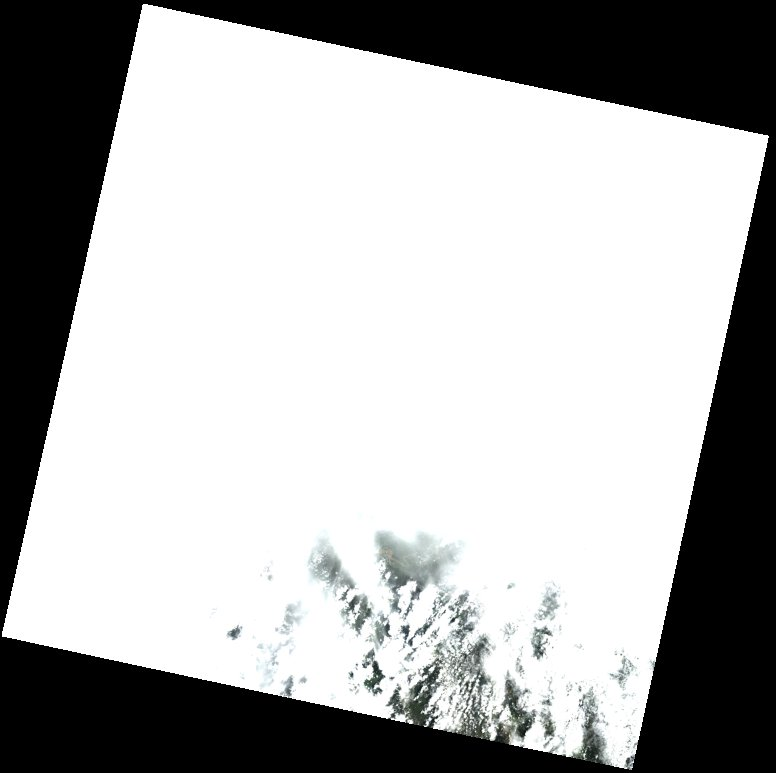

index: 64  Image: ga_ls8c_nbart_3-2-1_106069_2024-02-29_final_thumbnail.jpg


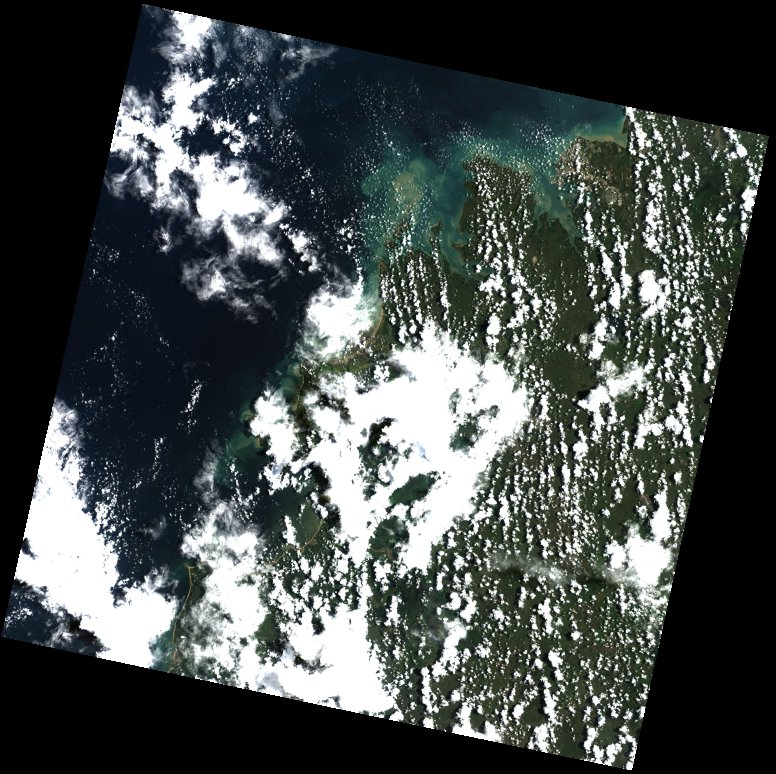

index: 65  Image: ga_ls8c_nbart_3-2-1_106069_2024-03-16_final_thumbnail.jpg


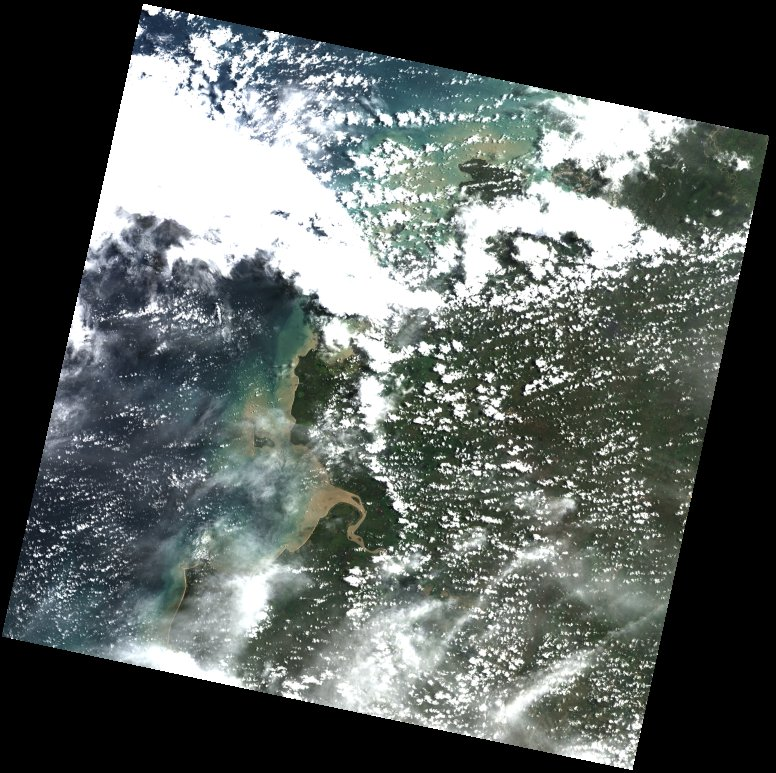

index: 66  Image: ga_ls8c_nbart_3-2-1_106069_2024-04-01_final_thumbnail.jpg


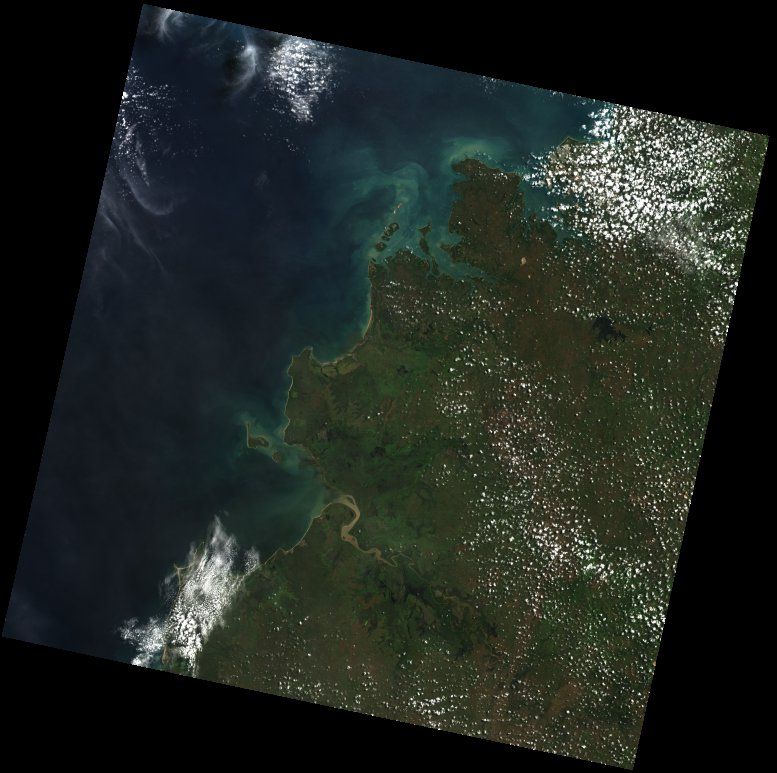

index: 67  Image: ga_ls8c_nbart_3-2-1_106069_2024-04-17_final_thumbnail.jpg


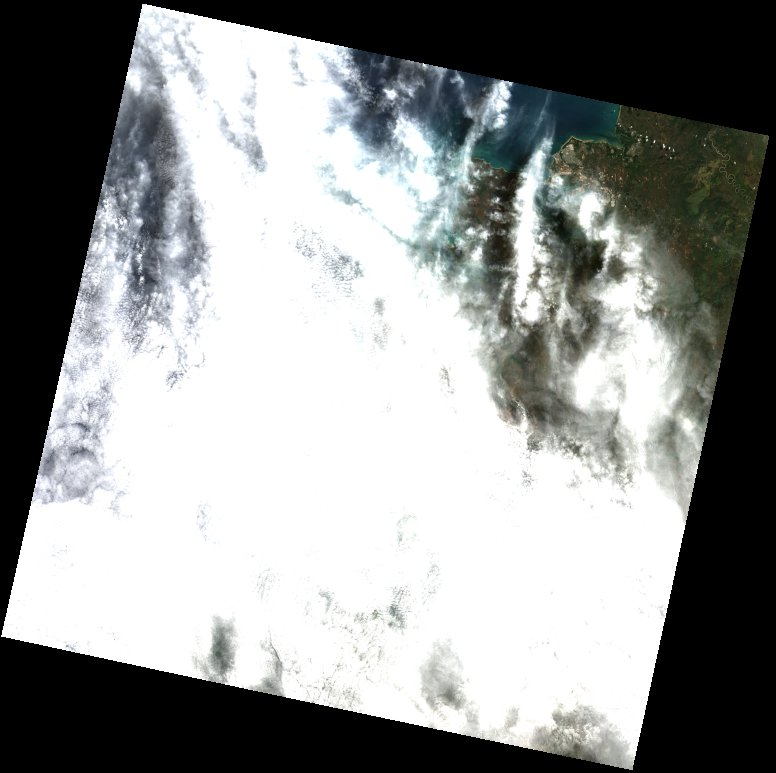

index: 68  Image: ga_ls8c_nbart_3-2-1_106069_2024-05-03_final_thumbnail.jpg


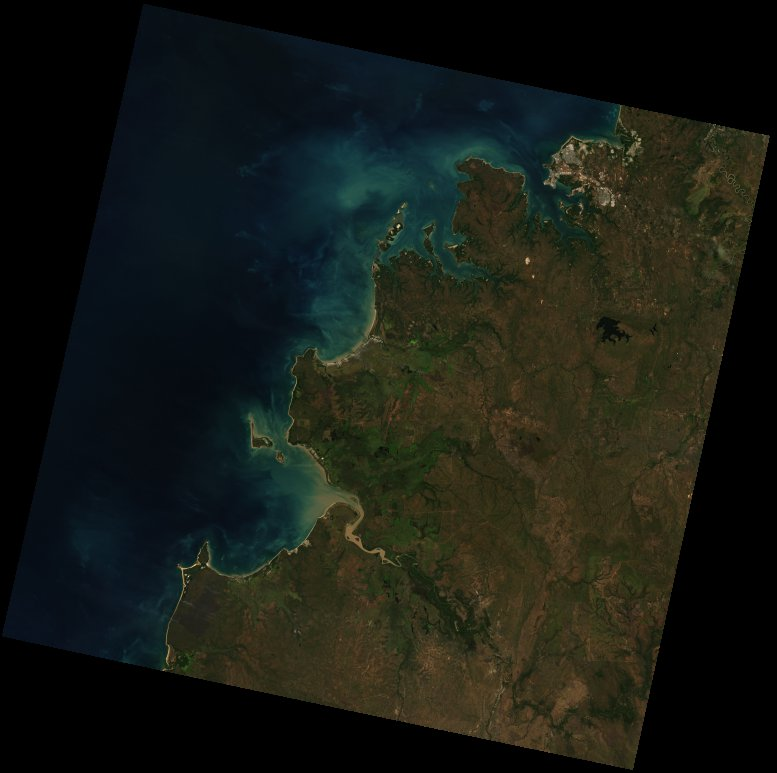

index: 69  Image: ga_ls8c_nbart_3-2-1_106069_2024-05-19_final_thumbnail.jpg


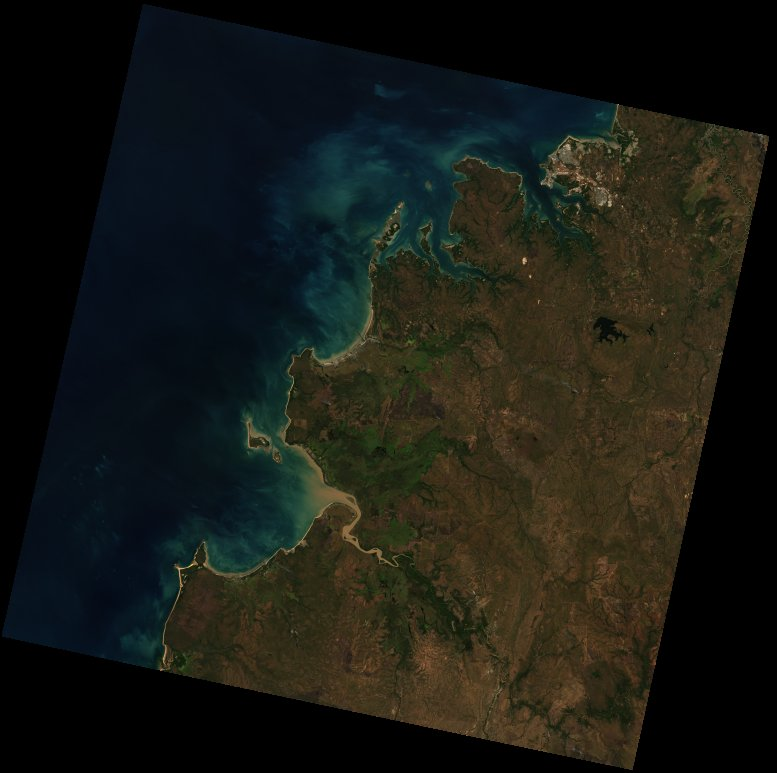

index: 70  Image: ga_ls8c_nbart_3-2-1_106069_2024-06-04_nrt_thumbnail.jpg


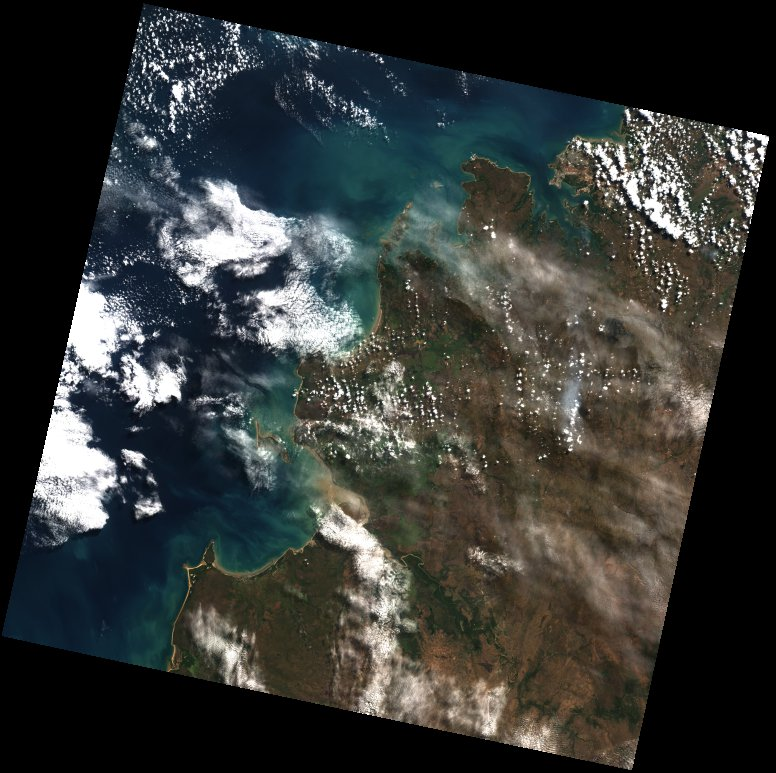

index: 71  Image: ga_ls8c_nbart_3-2-1_106069_2024-06-20_nrt_thumbnail.jpg


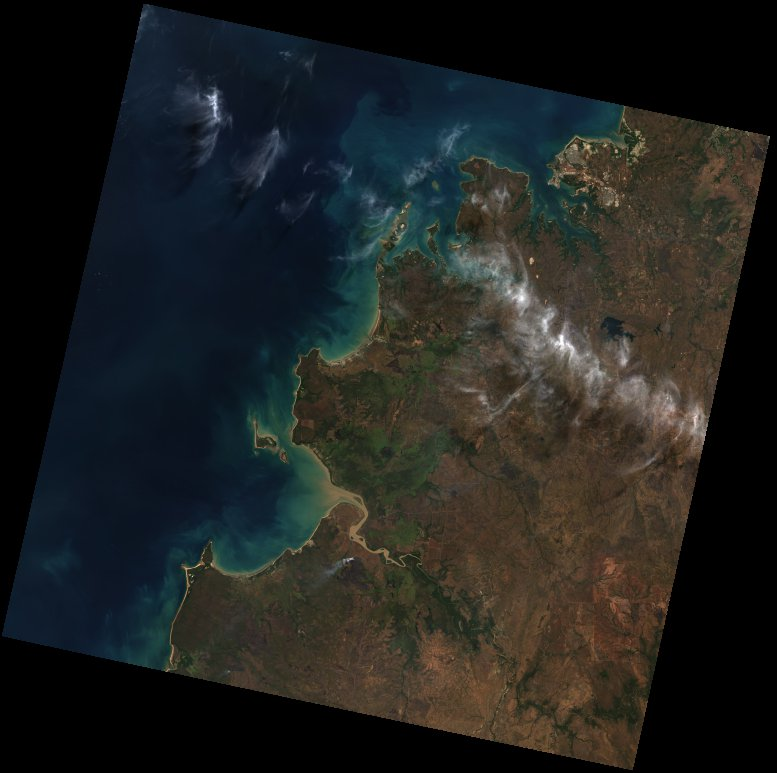

In [16]:
from IPython.display import Image

# for some reason DEA have decided to not provide thumbnails for some image dates (annoying!)
# the error will be ignored so be aware that you will only see the thumbnails that are avilable!

for i in cl.index:        
    try:
        stac_item = data['features'][i]
        url = stac_item['assets']['thumbnail:nbart']['href']
        jpg = odc.aws.s3_download(url)
        print ('index:',i ,' Image:', jpg)
        display(Image(filename=jpg,width = 800, height = 800))
        os.remove(jpg)
    except:
        print ('Sorry there are no thumbnails available for: '+ 'Index:',i ,' image:', cl.title[i] +'\n'+'\n'+'Click here https://maps.dea.ga.gov.au/ if you would like to look at a particular image before downloading it.'+'\n'+ 'Here are your centre cordinates for your Landsat Scene to input into DEA maps: ' + str(bbox[1:3])+'\n'+'\n''**************************************************************************************************************************')
        pass


### You have two options when selecting which imagery to download;
1. Download everything (be careful this code will automatically download and process every image in your stac query)   
2. Download a single of multiple scenes based on the index.


In [17]:
"""
Select the imagery you want to download by editing the intergers in the select variable 

Single example: select = [0] 
multiple example: select = [0,4,23]
"""
select = [23]

"""un-hash the next line to download and process all imagery returned in your stac query """
#select = cl.index

'un-hash the next line to download and process all imagery returned in your stac query '

### Download and process the selected imagery to produce a composite image from the Landsat bands and associated mask layers. 
- Six bands will be downloaded for Landsat 5 & 7 and Seven bands for Landsat 8 & 9. 
- The code will automatically download all the selected imagery onto your local working drive and then file them on the corporate file store. Note: it may take some time to copy the imagery to the corporate file store.  
- By default this code will download the nbart product, if you require the nbar product un-hash the bands list below

In [18]:
l57_bands = ['nbart_blue','nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2']

l89_bands = ['nbart_coastal_aerosol','nbart_blue','nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2']

oa = ['oa_fmask','oa_combined_terrain_shadow']

for i in select:#cl.index:# select:
    
    # select the correct bands to download based on the sensor
    imageName = (str(cl['title'][i]).split('_'))
    sensor = imageName[1] 
    
    if sensor == 'ls5t':
        bands = l57_bands
        
    if sensor == 'ls7e':
        bands = l57_bands
        
    if sensor == 'ls8c':
        bands = l89_bands
    
    elif sensor == 'ls9c':
        bands = l89_bands
        
    stac_item = data['features'][i]
    urls = [asset['href'] for asset in stac_item['assets'].values()]
    
    # make a directory to save the current landsat image into your local working drive
    image_dir = (str(cl['title'][i]))
       
    os.makedirs(image_dir)
    os.chdir(image_dir)
    print (os.getcwd())
        
    for band in bands:
        url = stac_item['assets'][band]['href']
        odc.aws.s3_download(url)
        
    file_list = []
    
    for file in glob.glob("*.tif"):
        print (file)
        file_list.append(file)
    
    comp_file_name = file_list[0][:-10] + 'comp.tif'
    
    band_list = file_list

    # Read metadata of first file
    with rasterio.open(band_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count= len(band_list))

    # Read each layer and write it to stack
    with rasterio.open(comp_file_name, 'w', **meta, compress='lzw') as dst:
        for id, layer in enumerate(band_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
                
    for file in band_list:
        os.remove(file) 
    print("Individual bands have been deleted") 
    
    # download the two mask products 
    
    for file in oa:
        url = stac_item['assets'][file]['href']
        odc.aws.s3_download(url)

    
    # move the files to the corporate storage location once all files have been downloaded and processed. 
        
    def make_dir(directory):
        """ Check if the directory already exists and create it if required.

        :param directory: string object containing the directory for the landsat imagery.
        """
        check_dir = os.path.exists(directory)
        if check_dir:
            pass
        else:
            os.mkdir(directory)
            print('directory created..')
        
    scratch_dir = str(os.getcwd())  
    
    # path to the DCCEEW corporate directory to store the imagery. 
    path = file_store
    
    for file in glob.glob("{0}\\*.tif".format(scratch_dir)):
    
        file_list_ = file.rsplit('\\', 1)
        file_name = file_list_[1]
       
        file_list = file_name.split('_')
 
        pathrow = file_list[4]

        file_date = file_list[5]
        
        pathrow_ = pathrow[:3] + '_' + pathrow[3:]
        
        file_date_list = file_date.split('-')

        file_year = file_date_list[0]
        
        file_month_ = file_date_list[1]

        file_day_ = file_date_list[2]

        newPathRow = os.path.join(path, pathrow_)

        make_dir(newPathRow)
        
        newPathRow_year = os.path.join(path, pathrow_, file_year)

        make_dir(newPathRow_year)
          
        newPathRow_year_month = os.path.join(path, pathrow_, file_year, file_year + file_month_)
        
        make_dir(newPathRow_year_month)
 
        # format the new directory path to put the file into
        output = '{0}\\{1}'.format(newPathRow_year_month, file_name)

        print('-- file: ', file)
        
        if os.path.exists(file):
            if os.path.exists(output):
                print('- ', file)
                print('-- Already exists')

            else:
                shutil.copy(file, output)
                print('- ', file)
                print('-- Copied to: ', output)    
 
    os.chdir("..")
    print (os.getcwd())

D:\data\working\temp_image\ga_ls8c_ard_3-2-1_106069_2022-05-14_final
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band01.tif
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band02.tif
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band03.tif
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band04.tif
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band05.tif
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band06.tif
ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_band07.tif
Individual bands have been deleted
directory created..
directory created..
-- file:  D:\data\working\temp_image\ga_ls8c_ard_3-2-1_106069_2022-05-14_final\ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_comp.tif
-  D:\data\working\temp_image\ga_ls8c_ard_3-2-1_106069_2022-05-14_final\ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_comp.tif
-- Copied to:  D:\\data\\working\\lsat\\test\\106_069\2022\202205\ga_ls8c_nbart_3-2-1_106069_2022-05-14_final_comp.tif
-- file:  D:\data\working\temp_image\ga_ls8c_ard_3-2-1_106069_2022-05-14_final\ga_ls8c_oa_3-2-1